# Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from itertools import combinations
from scipy.stats import spearmanr, kendalltau

In [3]:
import matplotlib

Chart Styling

In [4]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.spines.top'] = 'False'
matplotlib.rcParams['axes.spines.right'] = 'False'
matplotlib.rcParams['axes.spines.left'] = 'False'
matplotlib.rcParams['axes.spines.bottom'] = 'False'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.grid.axis'] = 'y'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20 
matplotlib.rcParams['legend.markerscale'] = 2
matplotlib.rcParams['legend.fontsize'] = 18 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

<ipython-input-4-4edcb8c67b7b>:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [5]:
palette = sns.color_palette(["#1D1128", "#EF946C", "#065A82","#66101F", "#7FD1B9", "#9B8816"])

# Methods

In [6]:
def computeMAE(exact, approx):
    if len(exact) == 0: 
        return 0.0
    if len(approx) == 0:
        return 1.0
    cum_sum = sum(np.array([abs(exact[x] - approx[x]) for x in approx if x in exact]))
    return (1. / len(approx)) * cum_sum

In [7]:
def computeME(exact, approx):
    if len(exact) == 0:
        return (0.0, -1)
    if len(approx) == 0:
        return (1.0, 0)
    tmp = np.array([(abs(exact[x] - approx[x]), len(x.split("-")[0].split(" "))) for x in approx if x in exact])
    tmp = sorted(tmp, key=lambda x: -x[0])
    return tmp[0]

In [8]:
def computePrecision(exact, approx):
    if len(approx) == 0:
        return 1.0
    if len(exact) == 0:
        return 0.0
    return 1. * len([x for x in approx if x in exact]) / len(approx)

In [9]:
def computeRecall(exact, approx):
    if len(exact) == 0:
        return 1.0
    if len(approx) == 0:
        return 0.0
    return 1. * len([x for x in approx if x in exact]) / len(exact)

In [10]:
def computeF1(exact, approx):
    prec = computePrecision(exact, approx)
    rec = computeRecall(exact, approx)
    if prec == 0.0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

In [11]:
def computeRankCorrelations(exact, approx):
    if len(exact) == 0 and len(approx) == 0:
        return (1.0,1.0)
    if len(exact) == 0 or len(approx) == 0:
        return (0.0,0.0)
    
    size = min(len(exact), len(approx))
    exact_freqs = []
    approx_freqs = []
    
    tmp = sorted(approx.items(), key=lambda x: -x[1])
    for i in range(size):
        approx_freqs.append(tmp[i][1])
        exact_f = 0
        if tmp[i][0] in exact: 
            exact_f = exact[tmp[i][0]]
        exact_freqs.append(exact_f)
    return (spearmanr(exact_freqs, approx_freqs)[0], kendalltau(exact_freqs, approx_freqs)[0])

In [12]:
 def load_patterns(f):
    patterns = {}
    epsilons = []
    with open(f) as in_f:
        for line in in_f.readlines():
            if line:
                lst = line.split("\t")
                if len(lst) == 1:
                    eps = float(lst[0])
                    store = True
                else:
                    freq = float(lst[0])
                    if len(lst[2].strip()) > 2:
                        patterns[lst[1].strip() + "-" + lst[2].strip()] = freq
                        if store:
                            epsilons.append(eps)
                            store = False
    while len(epsilons) < 4:
        epsilons.append(0)
    return (patterns, np.array(epsilons))

In [13]:
def rename_sample_size(s):
    sample_name = s/1000
    if sample_name == int(sample_name):
        return f's{int(sample_name)}k'
    return f's{sample_name}k'

In [14]:
def rename_sample_size_with_alpha(n):
    lst = n.split(' ')
    s = float(lst[0])
    a = lst[1]
    if a == '1.0':
        a = ''
    else:
        a = r'-$\alpha$'+a
    sample_name = s/1000
    if sample_name == int(sample_name):
        return f's{int(sample_name)}k{a}'
    return f's{sample_name}k{a}'

In [15]:
def rename_alpha(s):
    if s == 1.0:
        s = '1'
    return r'$\alpha$='+str(s)

In [16]:
def compute_metrics(folder, exact, d, freq, size, alpha, f, stats, stats_ex):
    mae = me = f1 = spearman = kendall = div = pr = re = 0
    avgeps = np.zeros(4)
    for seed in seeds:
        file_name = f'MANIAC_{d}_F{freq}P5{f}AX{size}S{seed}'
        try:
            pa = load_patterns(folder+file_name)
            approx = pa[0]
            if len(pa[1]) > 4:
                avgeps += pa[1][1:]
            else:
                avgeps += pa[1]
            div += 1
        except:
#             print(file_name)
            continue
        me_p = computeME(exact, approx)
        me += me_p[0]
        mae += computeMAE(exact, approx)
        f1 += computeF1(exact, approx)
        pr += computePrecision(exact, approx)
        re += computeRecall(exact, approx)
        if len(approx) > 1:
            corr = computeRankCorrelations(exact, approx)
            spearman += corr[0]
            kendall += corr[1]
    if div > 0:
        try:
            runtime = stats[(stats['Freq. Threshold']==freq) & 
                        (stats['Sample Size']==size) &
                        (stats['Alpha']==alpha)]['Time'].values[0]
        
            runtime_exact = stats_ex[(stats_ex['Freq. Threshold']==freq)]['Time'].values[0]
        except:
            runtime_exact = runtime = 1.
        return ["{:.3f}".format(runtime), "{:.3f}".format(runtime_exact/runtime), 
                me/div, mae/div, pr/div, re/div, f1/div, spearman/div, kendall/div, 
                avgeps[0]/div, avgeps[1]/div, avgeps[2]/div, avgeps[3]/div]
    return None

# Data Folder

In [17]:
data_dir = '/Users/giulia/Desktop/output/'
fig_path = '../approximatefsm/journal/figures/'

# Params

In [18]:
graph_names = {'youtube.lg' : 'YouTube',
              'patents_decade.lg': 'Patents',
              'mico.lg' : 'MiCo',
              'citeseer.lg': 'Citeseer',
              'phy_citations_grouped.lg': 'Phy-Cit'}
datasets = list(graph_names.keys())[:-2]

In [19]:
seeds = [1, 3, 5, 7, 11]
alphas = [0.1, 0.4, 0.7, 0.8, 0.9, 1.]

In [20]:
sample_sizes = {
    'patents_decade.lg' : [9000, 18000, 24000],
    'mico.lg' : [9000, 18000, 48000],
    'youtube.lg' : [120000, 240000, 600000]
}

subset_sizes = {
    'patents_decade.lg' : [24000],
    'mico.lg' : [48000],
    'youtube.lg' : [600000]
}

In [21]:
freqs = {'mico.lg' : [0.2,0.18,0.16,0.14,0.12,0.09],
         'citeseer.lg' : [0.13,0.12,0.11,0.1,0.09,0.08,0.07],
         'phy_citations_grouped.lg' : [0.2,0.18,0.17,0.16,0.15,0.11,0.09],
         'patents_decade.lg' : [0.3,0.27,0.25,0.23,0.21,0.2,0.18,0.17,0.16],
         'youtube.lg' : [0.13,0.12,0.11,0.1,0.09,0.08,0.07]}

subset_freqs = { 'mico.lg' : [0.09],
                 'youtube.lg' : [0.09],
                 'patents_decade.lg' : [0.18]}

# Load Statistics

In [22]:
stats = pd.read_csv(data_dir+'exact/statistics.csv', sep='\t', header=None,
                    names=['Dataset','timestamp', 'Time', 'Patterns', 'Freq. Threshold', 
                           'max_size', 'is_pregenerated', 'Sample Size', 'seed'])

In [23]:
stats['Alpha'] = 1.

In [24]:
for alpha in alphas:
    tmp = pd.read_csv(f'{data_dir}alpha_{alpha}/statistics.csv', sep='\t', 
                      header=None, names=['Dataset','timestamp', 'Time', 'Patterns', 
                                          'Freq. Threshold', 'max_size', 'is_pregenerated', 
                                          'Sample Size', 'seed'])
    tmp['Alpha'] = alpha
    stats = stats.append(tmp)
stats.drop(['timestamp', 'seed', 'is_pregenerated', 'max_size'], axis=1, inplace=True)
stats

,Dataset,Time,Patterns,Freq. Threshold,Sample Size,Alpha
0,citeseer.lg,2.799,8,0.15,EX,1.0
1,citeseer.lg,2.704,8,0.14,EX,1.0
2,citeseer.lg,2.856,10,0.13,EX,1.0
3,citeseer.lg,2.939,10,0.12,EX,1.0
4,citeseer.lg,3.156,10,0.11,EX,1.0
...,...,...,...,...,...,...
215,youtube.lg,52.148,6,0.11,240000,1.0
216,youtube.lg,99.560,10,0.10,240000,1.0
217,youtube.lg,232.224,16,0.09,240000,1.0
218,youtube.lg,704.638,28,0.08,240000,1.0


## Prepare Data

In [25]:
stats_d = {}
stats_ex_d = {}

In [26]:
for d in datasets:
    tmp = stats[(stats['Dataset']==d) & (stats['Sample Size']!='EX')].copy()
    tmp1 = tmp.groupby(by=['Freq. Threshold', 'Sample Size', 'Alpha']).mean().reset_index()
    stats_d[d] = tmp1[['Freq. Threshold', 'Sample Size', 'Alpha', 'Time', 'Patterns']]
    tmp2 = stats[(stats['Dataset']==d) & (stats['Sample Size']=='EX')].copy()
    tmp2 = tmp2.groupby(by=['Freq. Threshold']).mean().reset_index()
    stats_ex_d[d] = tmp2[['Freq. Threshold', 'Time', 'Patterns']]

## Time Statistics

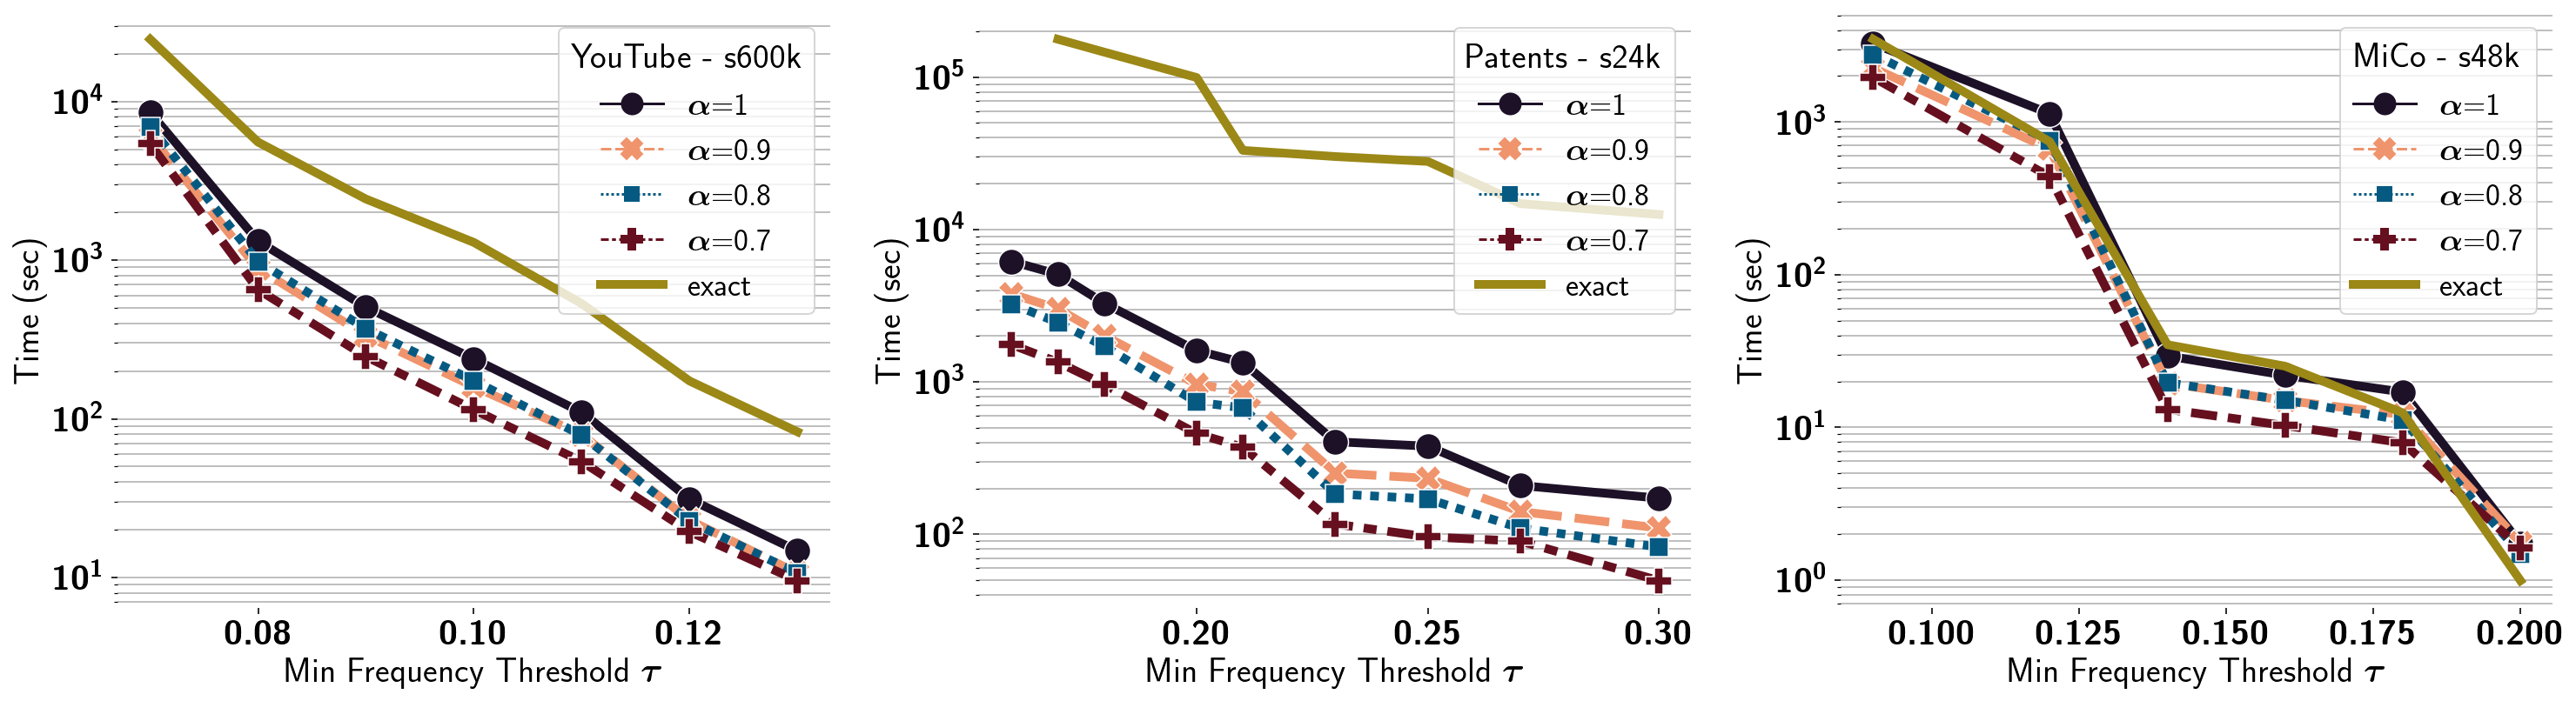

In [27]:
fig1, ax1 = plt.subplots(1,3, figsize=(21,6))
for idx1,d in enumerate(datasets):
    # prepare data
    data = stats_d[d][(stats_d[d]['Sample Size'].isin(subset_sizes[d])) & 
                      (stats_d[d]['Freq. Threshold'].isin(freqs[d])) &
                      (stats_d[d]['Alpha']).isin([0.7, 0.8, 0.9, 1.])].copy()
    data['Sample Size'] = data['Sample Size'].apply(str) + ' ' + data['Alpha'].apply(str)
    data['Sample Size'] = data['Sample Size'].apply(rename_sample_size_with_alpha)
    data = data.sort_values(by='Alpha', ascending=False)
    data['Alpha'] = data['Alpha'].apply(rename_alpha)
    # plot
    sns.lineplot(data=data, x='Freq. Threshold', y='Time', hue='Alpha', style='Alpha',
                 linewidth=5, markers=True, markersize=15, ax=ax1[idx1], palette=palette[:4])
    sns.lineplot(data=stats_ex_d[d][stats_ex_d[d]['Freq. Threshold'].isin(freqs[d])], 
                 x='Freq. Threshold', y='Time', linewidth=5, markers=True, markersize=10, 
                 label='exact', ax=ax1[idx1], color=palette[-1])
    # style 
    ax1[idx1].set_ylabel('Time (sec)')
    ax1[idx1].set_yscale('log')
    ax1[idx1].grid(axis='y', which='both')
    ax1[idx1].set_xlabel(r'Min Frequency Threshold $\tau$')
    # legend
    legend = ax1[idx1].legend()
    for line in legend.get_lines():
        line.set_linewidth(3)
    for marker in legend.legendHandles:
        marker._legmarker.set_markersize(10)
    ax1[idx1].legend(title=graph_names[d]+' - '+rename_sample_size(subset_sizes[d][0]))
plt.tight_layout()
plt.savefig(fig_path+f'runtime_vary_alpha.pdf', bbox_inches='tight')
plt.show()

## Number of Frequent Patterns Found

YouTube


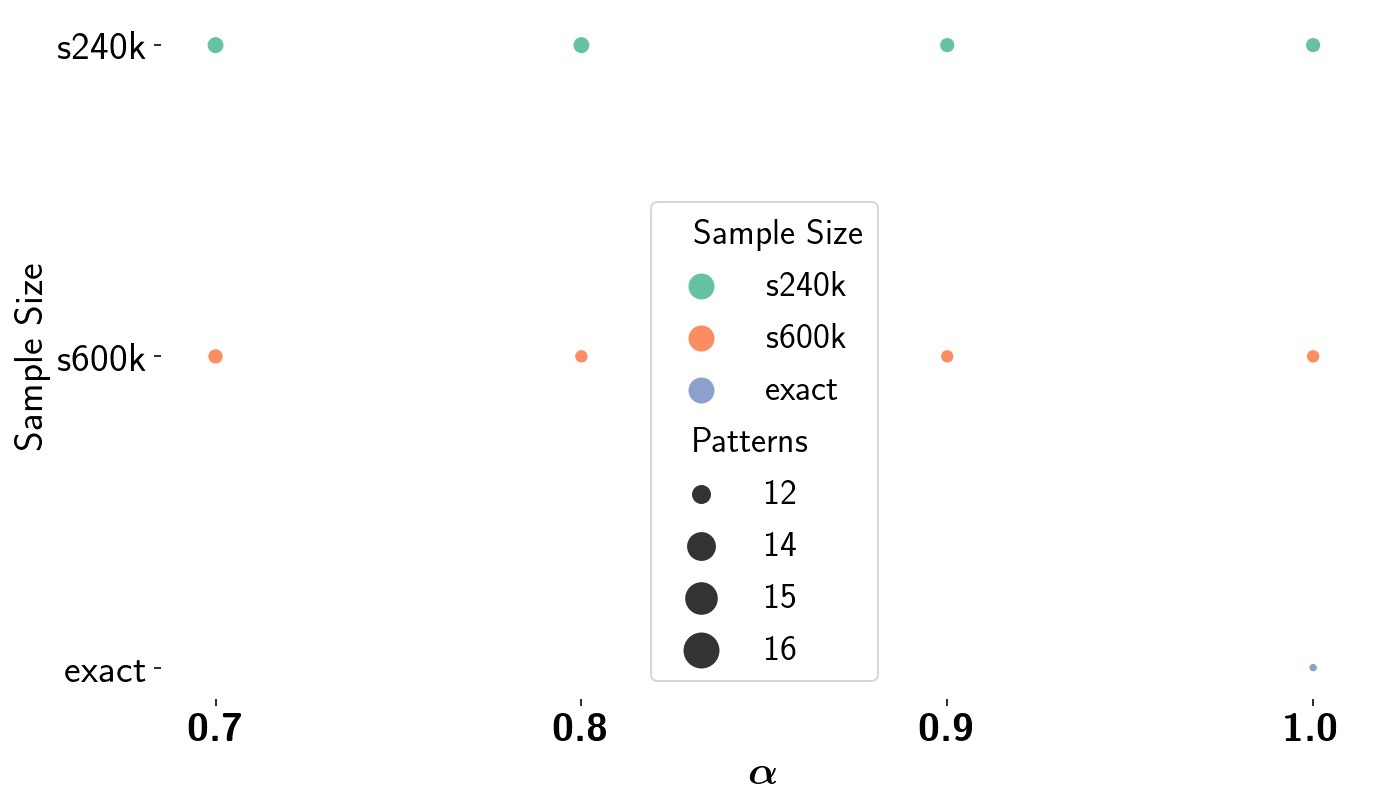

Patents


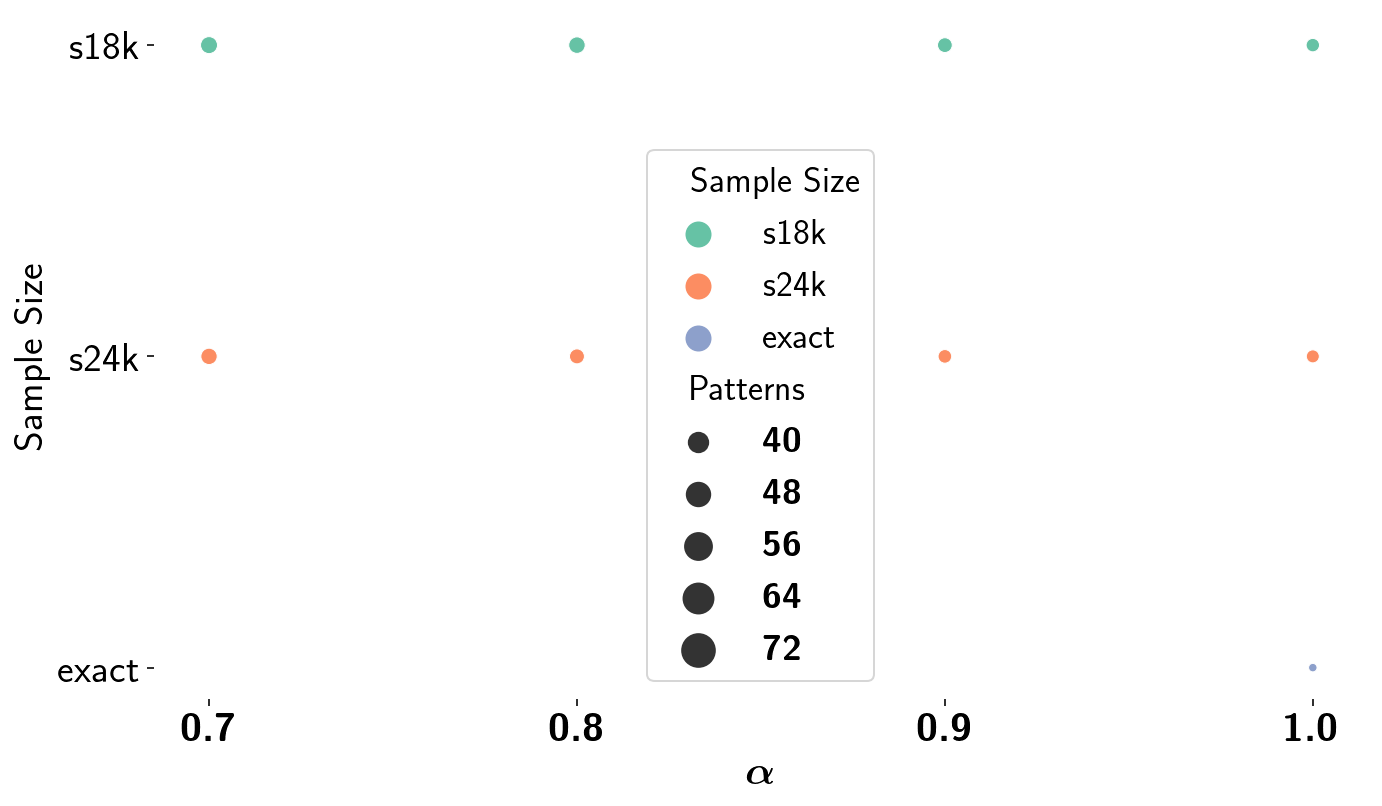

MiCo


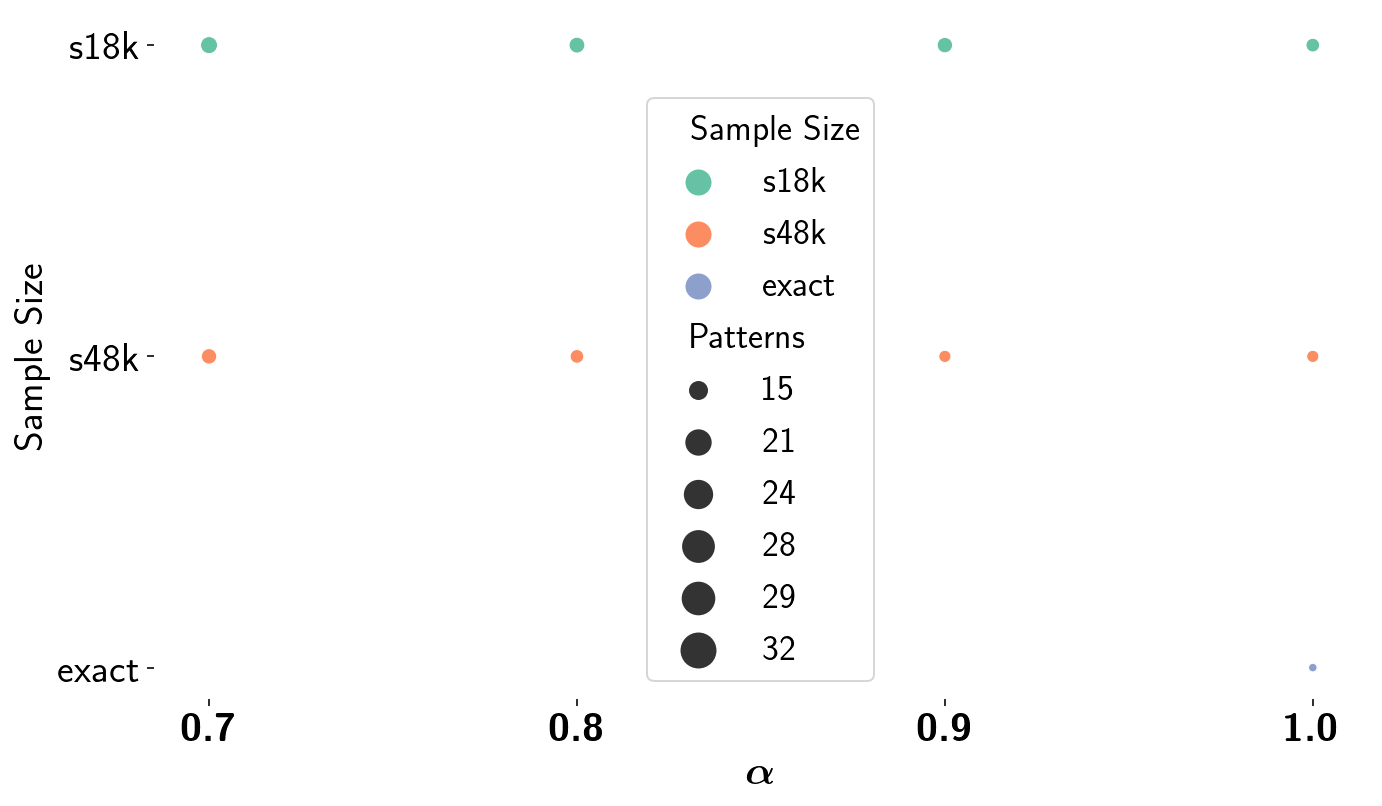

In [28]:
for d in datasets:
    print(graph_names[d])
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    # prepare data
    data = stats_d[d][(stats_d[d]['Freq. Threshold'].isin(subset_freqs[d])) &
                      (stats_d[d]['Alpha']>0.4) &
                      (stats_d[d]['Sample Size'].isin(sample_sizes[d]))].copy()
    data = data.astype(dtype={'Patterns':np.int32})
    data['Strategy'] = data['Sample Size'].apply(str) + ' ' + data['Alpha'].apply(str)
    data['Strategy'] = data['Strategy'].apply(rename_sample_size_with_alpha)
    data['Sample Size'] = data['Sample Size'].apply(rename_sample_size)
    exact = stats_ex_d[d][stats_ex_d[d]['Freq. Threshold'].isin(subset_freqs[d])].copy()
    exact['Strategy'] = 'exact'
    exact['Sample Size'] = 'exact'
    exact['Alpha'] = 1.0
    data = data.append(exact)
    
    sns.scatterplot(data=data, x='Alpha', y='Sample Size', palette='Set2', size='Patterns', hue='Sample Size')
    
    # style
    ax.set_xticks(alphas[2:])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Sample Size')
    # legend
    plt.tight_layout()
    plt.savefig(fig_path+f'avg_patterns_alpha_{d}.pdf', bbox_inches='tight')
    plt.show()

# Load Pattern Files

In [28]:
patterns_stats_m = []

for d in datasets:
    for freq in freqs[d]:
        exact_file = f"exact/MANIAC_{d}_F{freq}P5FEX0"
        try:
            pa = load_patterns(data_dir + exact_file)
            exact = pa[0]
        except:
            continue
        for alpha in alphas[2:]:
            for size in sample_sizes[d]:
                folder = f'{data_dir}alpha_{alpha}/'
                metrics = compute_metrics(folder, exact, d, freq, size, alpha, 'F', stats_d[d], stats_ex_d[d])
                if metrics is not None:
                    patterns_stats_m.append(np.concatenate(([d, freq, alpha, size], metrics)))

## Measure Error and F1

In [29]:
patterns_stats = pd.DataFrame(patterns_stats_m, columns=['Dataset','Freq. Threshold','Alpha',
                                                         'Sample Size', 'Time', 'Improvement', 'MaxAE','MAE', 
                                                         'Precision', 'Recall', 'F1','Spearman',
                                                         'Kendall', 'e2', 'e3', 'e4', 'e5'])
patterns_stats = patterns_stats.astype(dtype={'Freq. Threshold':np.float64,
                                            'Alpha':np.float64,
                                            'Sample Size':np.int32,
                                            'MaxAE':np.float64,
                                            'MAE':np.float64,
                                            'Precision':np.float64,
                                            'Recall':np.float64, 
                                            'F1': np.float64,
                                            'Spearman':np.float64,
                                            'Kendall':np.float64, 
                                            'e2':np.float64, 
                                            'e3':np.float64, 
                                            'e4':np.float64, 
                                            'e5':np.float64})
patterns_stats

,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
0,youtube.lg,0.13,0.7,240000,5.346,15.497,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,youtube.lg,0.13,0.7,600000,9.550,8.674,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,youtube.lg,0.13,0.8,240000,5.683,14.576,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,youtube.lg,0.13,0.8,600000,10.656,7.774,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,youtube.lg,0.13,0.9,240000,5.640,14.689,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,mico.lg,0.09,0.8,48000,2768.666,1.258,0.003261,0.001047,0.561905,1.0,0.717576,0.994406,0.975758,0.007997,0.009809,0.011859,0.014881
164,mico.lg,0.09,0.9,18000,2389.586,1.458,0.004700,0.001363,0.476615,1.0,0.645424,0.990210,0.963636,0.012313,0.014239,0.016229,0.019425
165,mico.lg,0.09,0.9,48000,2259.068,1.542,0.001628,0.000483,0.666667,1.0,0.800000,0.998601,0.993939,0.007540,0.008719,0.009938,0.011208
166,mico.lg,0.09,1.0,18000,2345.753,1.485,0.003873,0.001535,0.559080,1.0,0.714635,0.995804,0.987879,0.011681,0.012815,0.013856,0.015370


In [30]:
for d in datasets:
    this_stats = patterns_stats[patterns_stats['Dataset']==d]
    for f in this_stats['Freq. Threshold'].unique():
        if len(this_stats[this_stats['Freq. Threshold']==f]['Alpha'].unique()) > 1:
            display(this_stats[this_stats['Freq. Threshold']==f].sort_values(by='F1', ascending=False))

,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
0,youtube.lg,0.13,0.7,240000,5.346,15.497,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,youtube.lg,0.13,0.7,600000,9.550,8.674,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,youtube.lg,0.13,0.8,240000,5.683,14.576,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,youtube.lg,0.13,0.8,600000,10.656,7.774,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,youtube.lg,0.13,0.9,240000,5.640,14.689,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,youtube.lg,0.13,0.9,600000,10.643,7.784,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,youtube.lg,0.13,1.0,240000,6.695,12.373,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,youtube.lg,0.13,1.0,600000,14.708,5.632,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
9,youtube.lg,0.12,0.7,600000,19.444,8.905,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0
11,youtube.lg,0.12,0.8,600000,22.605,7.660,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0
13,youtube.lg,0.12,0.9,600000,22.951,7.544,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0
15,youtube.lg,0.12,1.0,600000,31.194,5.551,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0
14,youtube.lg,0.12,1.0,240000,14.900,11.621,0.0,0.0,0.8,1.0,0.8,0.0,0.0,0.000640,0.0,0.0,0.0
12,youtube.lg,0.12,0.9,240000,13.557,12.772,0.0,0.0,0.6,1.0,0.6,0.0,0.0,0.001349,0.0,0.0,0.0
8,youtube.lg,0.12,0.7,240000,11.080,15.628,0.0,0.0,0.2,1.0,0.2,0.0,0.0,0.003059,0.0,0.0,0.0
10,youtube.lg,0.12,0.8,240000,12.264,14.119,0.0,0.0,0.2,1.0,0.2,0.0,0.0,0.002861,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
16,youtube.lg,0.11,0.7,240000,29.603,17.984,0.000667,0.000418,1.0,1.0,1.0,1.0,1.0,0.003823,0.0,0.0,0.0
17,youtube.lg,0.11,0.7,600000,53.806,9.895,0.000474,0.000309,1.0,1.0,1.0,1.0,1.0,0.002418,0.0,0.0,0.0
18,youtube.lg,0.11,0.8,240000,34.585,15.394,0.000666,0.000397,1.0,1.0,1.0,1.0,1.0,0.003577,0.0,0.0,0.0
19,youtube.lg,0.11,0.8,600000,78.809,6.756,0.000437,0.000319,1.0,1.0,1.0,1.0,1.0,0.002262,0.0,0.0,0.0
20,youtube.lg,0.11,0.9,240000,39.037,13.638,0.000635,0.000399,1.0,1.0,1.0,1.0,1.0,0.003372,0.0,0.0,0.0
21,youtube.lg,0.11,0.9,600000,79.623,6.686,0.000456,0.000327,1.0,1.0,1.0,1.0,1.0,0.002133,0.0,0.0,0.0
22,youtube.lg,0.11,1.0,240000,49.479,10.760,0.000490,0.000288,1.0,1.0,1.0,1.0,1.0,0.003199,0.0,0.0,0.0
23,youtube.lg,0.11,1.0,600000,109.852,4.846,0.000350,0.000233,1.0,1.0,1.0,1.0,1.0,0.002023,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
24,youtube.lg,0.1,0.7,240000,62.990,20.539,0.000667,0.000279,0.666667,1.0,0.8,1.0,1.0,0.003823,0.0,0.0,0.0
25,youtube.lg,0.1,0.7,600000,114.080,11.341,0.000474,0.000206,0.666667,1.0,0.8,1.0,1.0,0.002418,0.0,0.0,0.0
26,youtube.lg,0.1,0.8,240000,73.377,17.631,0.000666,0.000265,0.666667,1.0,0.8,1.0,1.0,0.003577,0.0,0.0,0.0
27,youtube.lg,0.1,0.8,600000,173.629,7.451,0.000437,0.000213,0.666667,1.0,0.8,1.0,1.0,0.002262,0.0,0.0,0.0
28,youtube.lg,0.1,0.9,240000,89.978,14.378,0.000635,0.000266,0.666667,1.0,0.8,1.0,1.0,0.003372,0.0,0.0,0.0
29,youtube.lg,0.1,0.9,600000,159.757,8.098,0.000456,0.000218,0.666667,1.0,0.8,1.0,1.0,0.002133,0.0,0.0,0.0
30,youtube.lg,0.1,1.0,240000,103.634,12.484,0.000490,0.000192,0.666667,1.0,0.8,1.0,1.0,0.003199,0.0,0.0,0.0
31,youtube.lg,0.1,1.0,600000,238.657,5.421,0.000350,0.000155,0.666667,1.0,0.8,1.0,1.0,0.002023,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
37,youtube.lg,0.09,0.9,600000,335.398,7.236,0.000554,0.000193,0.660714,1.0,0.794872,1.0,1.0,0.002340,0.0,0.0,0.0
39,youtube.lg,0.09,1.0,600000,505.476,4.801,0.000402,0.000156,0.660714,1.0,0.794872,1.0,1.0,0.002220,0.0,0.0,0.0
35,youtube.lg,0.09,0.8,600000,369.707,6.564,0.000586,0.000204,0.646825,1.0,0.783883,1.0,1.0,0.002482,0.0,0.0,0.0
33,youtube.lg,0.09,0.7,600000,246.956,9.827,0.000634,0.000205,0.611111,1.0,0.758242,1.0,1.0,0.002653,0.0,0.0,0.0
36,youtube.lg,0.09,0.9,240000,199.920,12.139,0.000962,0.000233,0.569444,1.0,0.725275,1.0,1.0,0.003699,0.0,0.0,0.0
38,youtube.lg,0.09,1.0,240000,237.500,10.218,0.000749,0.000206,0.569444,1.0,0.725275,1.0,1.0,0.003510,0.0,0.0,0.0
32,youtube.lg,0.09,0.7,240000,146.632,16.550,0.000853,0.000225,0.544444,1.0,0.704762,1.0,1.0,0.004195,0.0,0.0,0.0
34,youtube.lg,0.09,0.8,240000,167.524,14.486,0.000938,0.000231,0.544444,1.0,0.704762,1.0,1.0,0.003924,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
47,youtube.lg,0.08,1.0,600000,1317.121,4.210,0.000523,0.000181,0.769591,1.0,0.869697,0.998242,0.991209,0.002220,0.000405,0.0,0.0
45,youtube.lg,0.08,0.9,600000,885.448,6.263,0.000656,0.000217,0.761404,1.0,0.864394,0.998242,0.991209,0.002340,0.000899,0.0,0.0
43,youtube.lg,0.08,0.8,600000,980.135,5.658,0.000723,0.000227,0.730292,1.0,0.843806,0.998242,0.991209,0.002482,0.002023,0.0,0.0
41,youtube.lg,0.08,0.7,600000,652.047,8.505,0.000844,0.000221,0.708070,1.0,0.828806,0.998242,0.991209,0.002653,0.002890,0.0,0.0
46,youtube.lg,0.08,1.0,240000,716.386,7.741,0.001021,0.000282,0.667273,1.0,0.800261,0.995604,0.982418,0.003510,0.003261,0.0,0.0
44,youtube.lg,0.08,0.9,240000,601.342,9.222,0.001065,0.000302,0.642424,1.0,0.782222,0.992088,0.969231,0.003699,0.003623,0.0,0.0
42,youtube.lg,0.08,0.8,240000,546.950,10.139,0.001135,0.000287,0.614229,1.0,0.760961,0.996484,0.982418,0.003924,0.004309,0.0,0.0
40,youtube.lg,0.08,0.7,240000,479.605,11.563,0.001116,0.000279,0.569333,1.0,0.725506,0.992088,0.969231,0.004195,0.005177,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
55,youtube.lg,0.07,1.0,600000,8534.262,2.890,0.000585,0.000167,0.782957,1.0,0.878257,0.996575,0.971018,0.002400,0.002568,0.002220,0.002220
53,youtube.lg,0.07,0.9,600000,6041.899,4.083,0.000801,0.000189,0.731943,1.0,0.844925,0.995574,0.966364,0.002530,0.002853,0.002726,0.002740
51,youtube.lg,0.07,0.8,600000,6931.694,3.559,0.000885,0.000199,0.649764,1.0,0.787478,0.994538,0.961599,0.002683,0.003210,0.003401,0.003694
54,youtube.lg,0.07,1.0,240000,5737.813,4.299,0.001141,0.000219,0.558847,1.0,0.716863,0.992071,0.950066,0.003795,0.004060,0.004007,0.003567
49,youtube.lg,0.07,0.7,600000,5421.658,4.550,0.001027,0.000185,0.523523,1.0,0.686964,0.993086,0.955676,0.002869,0.003668,0.004384,0.005035
52,youtube.lg,0.07,0.9,240000,5779.768,4.268,0.001179,0.000235,0.484934,1.0,0.652702,0.988153,0.935365,0.004000,0.004511,0.004813,0.004614
50,youtube.lg,0.07,0.8,240000,6430.430,3.836,0.001373,0.000174,0.362303,1.0,0.531763,0.989189,0.939569,0.004243,0.005075,0.006022,0.006733
48,youtube.lg,0.07,0.7,240000,6930.009,3.560,0.001491,0.000143,0.261021,1.0,0.413603,0.984467,0.922132,0.004536,0.006013,0.007438,0.009178


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
56,patents_decade.lg,0.3,0.7,18000,42.429,295.999,0.008113,0.005030,1.0,1.0,1.0,0.88,0.800000,0.013961,0.016687,0.019945,0.026155
57,patents_decade.lg,0.3,0.7,24000,49.696,252.720,0.004864,0.003201,1.0,1.0,1.0,1.00,1.000000,0.012091,0.014451,0.017273,0.022650
58,patents_decade.lg,0.3,0.8,18000,64.081,195.988,0.004579,0.003025,1.0,1.0,1.0,0.96,0.933333,0.013060,0.014601,0.016325,0.020024
59,patents_decade.lg,0.3,0.8,24000,82.572,152.097,0.004361,0.002188,1.0,1.0,1.0,0.96,0.933333,0.011310,0.012645,0.014138,0.017341
60,patents_decade.lg,0.3,0.9,18000,94.338,133.128,0.003900,0.001867,1.0,1.0,1.0,1.00,1.000000,0.012313,0.012979,0.013681,0.015821
61,patents_decade.lg,0.3,0.9,24000,110.055,114.116,0.003215,0.002118,1.0,1.0,1.0,1.00,1.000000,0.010663,0.011240,0.011848,0.013701
62,patents_decade.lg,0.3,1.0,18000,132.426,94.838,0.002592,0.001719,1.0,1.0,1.0,1.00,1.000000,0.011681,0.011681,0.011681,0.012815
63,patents_decade.lg,0.3,1.0,24000,172.817,72.673,0.002438,0.001696,1.0,1.0,1.0,1.00,1.000000,0.010116,0.010116,0.010116,0.011098


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
71,patents_decade.lg,0.27,1.0,24000,209.315,70.699,0.002438,0.001696,1.000000,1.0,1.00,1.00,1.000000,0.010116,0.010116,0.010116,0.011098
67,patents_decade.lg,0.27,0.8,24000,109.950,134.591,0.004361,0.002129,0.933333,1.0,0.96,0.96,0.933333,0.011310,0.012645,0.014412,0.017623
69,patents_decade.lg,0.27,0.9,24000,141.263,104.757,0.003215,0.001986,0.933333,1.0,0.96,1.00,1.000000,0.010663,0.011240,0.012078,0.013924
70,patents_decade.lg,0.27,1.0,18000,225.839,65.526,0.002592,0.001399,0.800000,1.0,0.88,1.00,1.000000,0.011681,0.011681,0.012361,0.013440
68,patents_decade.lg,0.27,0.9,18000,171.560,86.257,0.003900,0.001393,0.733333,1.0,0.84,1.00,1.000000,0.012313,0.012979,0.014743,0.016850
64,patents_decade.lg,0.27,0.7,18000,79.138,186.993,0.008113,0.003353,0.666667,1.0,0.80,0.88,0.800000,0.013961,0.016687,0.021881,0.028281
65,patents_decade.lg,0.27,0.7,24000,90.322,163.839,0.004864,0.002134,0.666667,1.0,0.80,1.00,1.000000,0.012091,0.014451,0.018950,0.024491
66,patents_decade.lg,0.27,0.8,18000,122.906,120.403,0.004579,0.002016,0.666667,1.0,0.80,0.96,0.933333,0.013060,0.014601,0.017909,0.021652


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
73,patents_decade.lg,0.25,0.7,24000,96.215,290.891,0.006174,0.003447,1.000000,1.0,1.000000,0.977143,0.946667,0.012091,0.014451,0.018950,0.024491
74,patents_decade.lg,0.25,0.8,18000,131.647,212.599,0.004741,0.002970,1.000000,1.0,1.000000,0.988571,0.973333,0.013060,0.014601,0.017909,0.021652
75,patents_decade.lg,0.25,0.8,24000,170.740,163.922,0.004361,0.002455,1.000000,1.0,1.000000,0.954286,0.893333,0.011310,0.012645,0.015510,0.018750
76,patents_decade.lg,0.25,0.9,18000,200.403,139.658,0.003900,0.001677,1.000000,1.0,1.000000,0.977143,0.946667,0.012313,0.012979,0.015009,0.017107
77,patents_decade.lg,0.25,0.9,24000,233.226,120.004,0.003244,0.002101,1.000000,1.0,1.000000,0.988571,0.973333,0.010663,0.011240,0.012998,0.014815
78,patents_decade.lg,0.25,1.0,18000,288.767,96.922,0.002740,0.001766,1.000000,1.0,1.000000,1.000000,1.000000,0.011681,0.011681,0.012815,0.013856
79,patents_decade.lg,0.25,1.0,24000,379.227,73.803,0.002603,0.001694,1.000000,1.0,1.000000,1.000000,1.000000,0.010116,0.010116,0.011098,0.012000
72,patents_decade.lg,0.25,0.7,18000,84.231,332.278,0.008113,0.004741,0.971429,1.0,0.984615,0.942857,0.866667,0.013961,0.016687,0.021881,0.028281


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
87,patents_decade.lg,0.23,1.0,24000,405.209,74.355,0.002603,0.001583,0.914286,1.0,0.953846,1.000000,1.000000,0.010116,0.010116,0.011098,0.012000
85,patents_decade.lg,0.23,0.9,24000,252.333,119.403,0.003244,0.001856,0.892857,1.0,0.940659,0.988571,0.973333,0.010663,0.011240,0.012998,0.014815
83,patents_decade.lg,0.23,0.8,24000,184.303,163.477,0.004361,0.002104,0.857143,1.0,0.923077,0.954286,0.893333,0.011310,0.012645,0.015510,0.018750
86,patents_decade.lg,0.23,1.0,18000,310.500,97.035,0.002740,0.001468,0.835714,1.0,0.909890,1.000000,1.000000,0.011681,0.011681,0.012815,0.013856
84,patents_decade.lg,0.23,0.9,18000,215.193,140.011,0.003900,0.001353,0.814286,1.0,0.896703,0.977143,0.946667,0.012313,0.012979,0.015009,0.017107
82,patents_decade.lg,0.23,0.8,18000,142.822,210.957,0.004741,0.002188,0.733333,1.0,0.845714,0.988571,0.973333,0.013060,0.014601,0.017909,0.021652
81,patents_decade.lg,0.23,0.7,24000,116.895,257.746,0.006174,0.002063,0.638182,1.0,0.775210,0.977143,0.946667,0.012091,0.014451,0.018950,0.024491
80,patents_decade.lg,0.23,0.7,18000,138.274,217.895,0.008113,0.002655,0.529091,1.0,0.684510,0.942857,0.866667,0.013961,0.017011,0.022237,0.028676


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
95,patents_decade.lg,0.21,1.0,24000,1341.543,24.656,0.003335,0.000681,0.409091,1.0,0.580645,0.993333,0.977778,0.010116,0.011098,0.012000,0.012839
93,patents_decade.lg,0.21,0.9,24000,863.677,38.298,0.003688,0.000783,0.399273,1.0,0.570398,0.990000,0.966667,0.010663,0.012331,0.014055,0.016045
94,patents_decade.lg,0.21,1.0,18000,1049.353,31.522,0.003536,0.000695,0.399273,1.0,0.570398,0.996667,0.988889,0.011681,0.012815,0.013856,0.015007
91,patents_decade.lg,0.21,0.8,24000,676.412,48.901,0.005454,0.000940,0.366261,1.0,0.536029,0.973333,0.911111,0.011310,0.013873,0.016771,0.021045
92,patents_decade.lg,0.21,0.9,18000,817.623,40.456,0.004020,0.000630,0.360000,1.0,0.529412,0.986667,0.955556,0.012313,0.014239,0.016229,0.019425
89,patents_decade.lg,0.21,0.7,24000,372.853,88.714,0.006991,0.001146,0.356177,1.0,0.524700,0.970000,0.911111,0.012091,0.015854,0.020490,0.027488
90,patents_decade.lg,0.21,0.8,18000,535.648,61.752,0.004741,0.000997,0.354667,1.0,0.523529,0.993333,0.977778,0.013060,0.016019,0.019365,0.024586
88,patents_decade.lg,0.21,0.7,18000,317.498,104.182,0.008733,0.001633,0.352419,1.0,0.520165,0.973333,0.911111,0.013961,0.018307,0.023990,0.031371


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
103,patents_decade.lg,0.2,1.0,24000,1605.686,61.938,0.003621,0.001415,0.873231,1.0,0.932270,0.979221,0.935931,0.010116,0.011098,0.012000,0.013626
102,patents_decade.lg,0.2,1.0,18000,1241.879,80.083,0.003925,0.001639,0.839886,1.0,0.912925,0.971088,0.930688,0.011681,0.012815,0.013856,0.015734
101,patents_decade.lg,0.2,0.9,24000,966.516,102.899,0.004416,0.001658,0.817026,1.0,0.897234,0.979613,0.930648,0.010663,0.012331,0.014251,0.016822
99,patents_decade.lg,0.2,0.8,24000,736.480,135.039,0.005971,0.001935,0.803175,1.0,0.890776,0.941208,0.842638,0.011310,0.013873,0.016771,0.021291
100,patents_decade.lg,0.2,0.9,18000,979.817,101.502,0.005025,0.001660,0.748833,1.0,0.850877,0.969841,0.910694,0.012313,0.014239,0.016683,0.019425
96,patents_decade.lg,0.2,0.7,18000,414.470,239.954,0.010712,0.003705,0.673977,1.0,0.801926,0.898806,0.787294,0.013961,0.018307,0.024982,0.032113
97,patents_decade.lg,0.2,0.7,24000,458.651,216.839,0.008952,0.002390,0.676424,1.0,0.801670,0.912181,0.821804,0.012091,0.015854,0.021349,0.027809
98,patents_decade.lg,0.2,0.8,18000,694.370,143.229,0.005900,0.002123,0.658526,1.0,0.790601,0.950924,0.875184,0.013060,0.016019,0.020448,0.024586


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
111,patents_decade.lg,0.18,1.0,24000,3288.582,44.386,0.003621,0.001020,0.649969,1.0,0.787010,0.992447,0.962121,0.011098,0.012000,0.012839,0.014221
110,patents_decade.lg,0.18,1.0,18000,2651.697,55.047,0.003973,0.001243,0.624784,1.0,0.766960,0.989956,0.959234,0.012815,0.013856,0.014825,0.016421
109,patents_decade.lg,0.18,0.9,24000,2014.083,72.474,0.004718,0.001253,0.603748,1.0,0.752465,0.985411,0.936166,0.011698,0.013333,0.015037,0.017741
108,patents_decade.lg,0.18,0.9,18000,1975.268,73.898,0.005569,0.001386,0.549468,1.0,0.708323,0.988753,0.945603,0.013508,0.015396,0.017363,0.020486
107,patents_decade.lg,0.18,0.8,24000,1715.447,85.091,0.006178,0.001159,0.541057,1.0,0.701155,0.976970,0.900686,0.012408,0.015000,0.017943,0.022454
106,patents_decade.lg,0.18,0.8,18000,1438.789,101.452,0.006168,0.001674,0.479670,1.0,0.645862,0.974531,0.904133,0.014328,0.017321,0.020718,0.025928
105,patents_decade.lg,0.18,0.7,24000,963.037,151.571,0.008952,0.001441,0.466102,1.0,0.635032,0.967575,0.890320,0.013265,0.017143,0.021922,0.029328
104,patents_decade.lg,0.18,0.7,18000,874.176,166.978,0.011296,0.002641,0.465810,1.0,0.631137,0.961140,0.873504,0.015317,0.019795,0.025934,0.033867


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
119,patents_decade.lg,0.17,1.0,24000,5084.612,34.866,0.004212,0.000830,0.520845,1.0,0.684863,0.995530,0.968549,0.011098,0.012000,0.013311,0.014370
118,patents_decade.lg,0.17,1.0,18000,3937.230,45.026,0.004827,0.000985,0.504899,1.0,0.670947,0.993310,0.961870,0.012815,0.013856,0.015552,0.016593
117,patents_decade.lg,0.17,0.9,24000,3020.849,58.685,0.005520,0.000996,0.493671,1.0,0.660854,0.990554,0.949150,0.011698,0.013333,0.015775,0.017741
116,patents_decade.lg,0.17,0.9,18000,2836.983,62.489,0.005786,0.001258,0.475062,1.0,0.643993,0.993287,0.954999,0.013508,0.015396,0.018428,0.020486
115,patents_decade.lg,0.17,0.8,24000,2457.164,72.148,0.006835,0.000954,0.463263,1.0,0.632931,0.986620,0.924425,0.012408,0.015000,0.019043,0.022896
114,patents_decade.lg,0.17,0.8,18000,1871.614,94.720,0.006701,0.001533,0.449887,1.0,0.620270,0.982338,0.919997,0.014328,0.017321,0.021989,0.026694
112,patents_decade.lg,0.17,0.7,18000,1186.000,149.476,0.011342,0.002312,0.436857,1.0,0.607605,0.971003,0.883897,0.015317,0.019795,0.026865,0.035201
113,patents_decade.lg,0.17,0.7,24000,1347.930,131.519,0.009046,0.001268,0.426335,1.0,0.597629,0.980442,0.915159,0.013265,0.017143,0.023266,0.030772


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
120,mico.lg,0.2,0.7,18000,1.075,0.922,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
121,mico.lg,0.2,0.7,48000,1.629,0.609,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
122,mico.lg,0.2,0.8,18000,1.008,0.985,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
123,mico.lg,0.2,0.8,48000,1.489,0.666,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
124,mico.lg,0.2,0.9,18000,1.163,0.853,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
125,mico.lg,0.2,0.9,48000,1.759,0.564,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
126,mico.lg,0.2,1.0,18000,1.128,0.880,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
127,mico.lg,0.2,1.0,48000,1.733,0.572,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
128,mico.lg,0.18,0.7,18000,3.787,3.289,0.002396,0.002396,1.0,1.0,1.0,0.0,0.0,0.013961,0.0,0.0,0.0
129,mico.lg,0.18,0.7,48000,7.928,1.571,0.001950,0.001950,1.0,1.0,1.0,0.0,0.0,0.008550,0.0,0.0,0.0
130,mico.lg,0.18,0.8,18000,4.489,2.775,0.002789,0.002789,1.0,1.0,1.0,0.0,0.0,0.013060,0.0,0.0,0.0
131,mico.lg,0.18,0.8,48000,11.149,1.117,0.001571,0.001571,1.0,1.0,1.0,0.0,0.0,0.007997,0.0,0.0,0.0
132,mico.lg,0.18,0.9,18000,5.479,2.273,0.003176,0.003176,1.0,1.0,1.0,0.0,0.0,0.012313,0.0,0.0,0.0
133,mico.lg,0.18,0.9,48000,12.136,1.026,0.001389,0.001389,1.0,1.0,1.0,0.0,0.0,0.007540,0.0,0.0,0.0
134,mico.lg,0.18,1.0,18000,6.224,2.001,0.002960,0.002960,1.0,1.0,1.0,0.0,0.0,0.011681,0.0,0.0,0.0
135,mico.lg,0.18,1.0,48000,17.034,0.731,0.001377,0.001377,1.0,1.0,1.0,0.0,0.0,0.007153,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
136,mico.lg,0.16,0.7,18000,4.452,5.654,0.002396,0.002396,1.0,1.0,1.0,0.0,0.0,0.013961,0.0,0.0,0.0
137,mico.lg,0.16,0.7,48000,10.282,2.448,0.001950,0.001950,1.0,1.0,1.0,0.0,0.0,0.008550,0.0,0.0,0.0
138,mico.lg,0.16,0.8,18000,5.430,4.635,0.002789,0.002789,1.0,1.0,1.0,0.0,0.0,0.013060,0.0,0.0,0.0
139,mico.lg,0.16,0.8,48000,15.076,1.670,0.001571,0.001571,1.0,1.0,1.0,0.0,0.0,0.007997,0.0,0.0,0.0
140,mico.lg,0.16,0.9,18000,6.613,3.806,0.003176,0.003176,1.0,1.0,1.0,0.0,0.0,0.012313,0.0,0.0,0.0
141,mico.lg,0.16,0.9,48000,15.014,1.677,0.001389,0.001389,1.0,1.0,1.0,0.0,0.0,0.007540,0.0,0.0,0.0
142,mico.lg,0.16,1.0,18000,8.237,3.056,0.002960,0.002960,1.0,1.0,1.0,0.0,0.0,0.011681,0.0,0.0,0.0
143,mico.lg,0.16,1.0,48000,21.980,1.145,0.001377,0.001377,1.0,1.0,1.0,0.0,0.0,0.007153,0.0,0.0,0.0


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
145,mico.lg,0.14,0.7,48000,13.140,2.649,0.002003,0.001523,1.000000,1.0,1.000000,1.0,1.0,0.008550,0.010219,0.000000,0.000000
147,mico.lg,0.14,0.8,48000,19.640,1.772,0.001893,0.001596,1.000000,1.0,1.000000,1.0,1.0,0.007997,0.008941,0.000000,0.000000
149,mico.lg,0.14,0.9,48000,19.469,1.788,0.001390,0.000934,1.000000,1.0,1.000000,1.0,1.0,0.007540,0.007948,0.000000,0.000000
151,mico.lg,0.14,1.0,48000,29.371,1.185,0.001377,0.001067,1.000000,1.0,1.000000,1.0,1.0,0.007153,0.007153,0.000000,0.000000
150,mico.lg,0.14,1.0,18000,28.596,1.217,0.003630,0.003055,0.900000,1.0,0.933333,1.0,1.0,0.011681,0.011908,0.002336,0.000000
148,mico.lg,0.14,0.9,18000,67.378,0.517,0.003698,0.002788,0.733333,1.0,0.826667,1.0,1.0,0.012313,0.013735,0.005472,0.000000
146,mico.lg,0.14,0.8,18000,38.453,0.905,0.003802,0.002625,0.680000,1.0,0.794286,1.0,1.0,0.013060,0.015735,0.003265,0.004005
144,mico.lg,0.14,0.7,18000,74.479,0.467,0.003611,0.001228,0.453333,1.0,0.617143,1.0,1.0,0.013961,0.018307,0.015956,0.020924


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
157,mico.lg,0.12,0.9,48000,664.949,1.118,0.001518,0.000698,0.800000,1.0,0.888889,1.00,1.000000,0.007540,0.008719,0.008378,0.009688
159,mico.lg,0.12,1.0,48000,1134.714,0.655,0.001377,0.000719,0.800000,1.0,0.888889,1.00,1.000000,0.007153,0.007848,0.007153,0.007848
158,mico.lg,0.12,1.0,18000,462.980,1.605,0.003834,0.002239,0.713333,1.0,0.826667,1.00,1.000000,0.011681,0.012815,0.012135,0.013023
155,mico.lg,0.12,0.8,48000,754.343,0.985,0.002467,0.001095,0.694286,1.0,0.812121,0.96,0.933333,0.007997,0.009809,0.010385,0.012461
153,mico.lg,0.12,0.7,48000,438.085,1.697,0.002881,0.001061,0.680000,1.0,0.800000,0.96,0.933333,0.008550,0.011211,0.012688,0.016537
156,mico.lg,0.12,0.9,18000,484.690,1.533,0.004439,0.002083,0.593333,1.0,0.737778,0.96,0.933333,0.012313,0.014239,0.014743,0.016593
154,mico.lg,0.12,0.8,18000,344.661,2.156,0.004746,0.001979,0.560000,1.0,0.711111,0.96,0.933333,0.013060,0.016019,0.017592,0.021326
152,mico.lg,0.12,0.7,18000,226.929,3.275,0.003922,0.000969,0.420000,1.0,0.590476,0.96,0.933333,0.013961,0.018307,0.021881,0.028281


,Dataset,Freq. Threshold,Alpha,Sample Size,Time,Improvement,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,e2,e3,e4,e5
165,mico.lg,0.09,0.9,48000,2259.068,1.542,0.001628,0.000483,0.666667,1.0,0.800000,0.998601,0.993939,0.007540,0.008719,0.009938,0.011208
167,mico.lg,0.09,1.0,48000,3265.236,1.067,0.001434,0.000453,0.666667,1.0,0.800000,1.000000,1.000000,0.007153,0.007848,0.008485,0.009078
163,mico.lg,0.09,0.8,48000,2768.666,1.258,0.003261,0.001047,0.561905,1.0,0.717576,0.994406,0.975758,0.007997,0.009809,0.011859,0.014881
166,mico.lg,0.09,1.0,18000,2345.753,1.485,0.003873,0.001535,0.559080,1.0,0.714635,0.995804,0.987879,0.011681,0.012815,0.013856,0.015370
161,mico.lg,0.09,0.7,48000,1961.543,1.776,0.003789,0.000889,0.480000,1.0,0.648649,0.988811,0.957576,0.008550,0.011211,0.014488,0.019664
164,mico.lg,0.09,0.9,18000,2389.586,1.458,0.004700,0.001363,0.476615,1.0,0.645424,0.990210,0.963636,0.012313,0.014239,0.016229,0.019425
162,mico.lg,0.09,0.8,18000,1497.179,2.327,0.005124,0.001319,0.458120,1.0,0.628340,0.987413,0.951515,0.013060,0.016019,0.019365,0.024586
160,mico.lg,0.09,0.7,18000,1104.104,3.155,0.005725,0.001094,0.414406,1.0,0.585795,0.979021,0.927273,0.013961,0.018307,0.023659,0.032113


## MaxAE vs Epsilon Values

In [31]:
freqs_mae = {'mico.lg': [0.18, 0.16, 0.14, 0.12, 0.09],
             'patents_decade.lg': [0.3, 0.27, 0.25, 0.23, 0.21, 0.2, 0.18, 0.17, 0.16],
             'youtube.lg': [0.11, 0.1, 0.09, 0.08, 0.07]
}

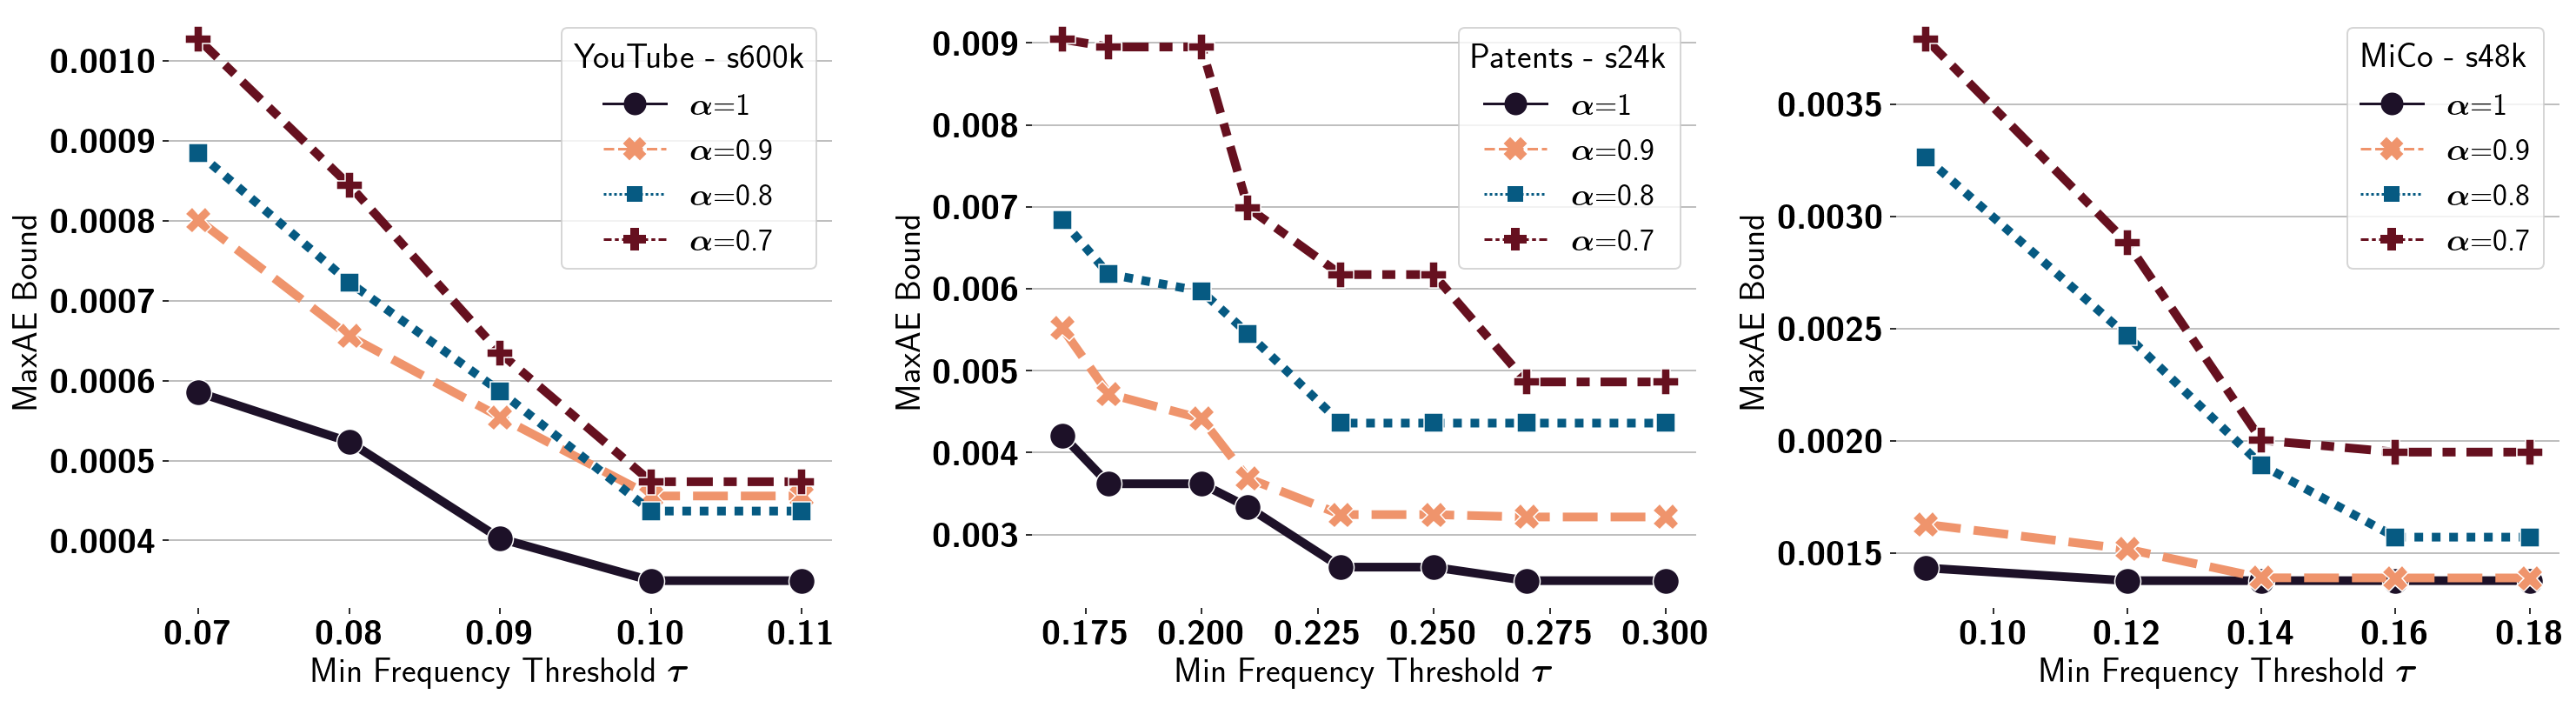

In [32]:
fig, ax = plt.subplots(1,3, figsize=(21,6))
for idx,graph in enumerate(datasets):
    
    data = patterns_stats[(patterns_stats['Dataset']==graph) & 
                          (patterns_stats['Sample Size'].isin(subset_sizes[graph])) & 
                          (patterns_stats['Freq. Threshold'].isin(freqs_mae[graph]))].copy()
    data['Strategy'] = (data['Sample Size'].apply(str) + ' ' + data['Alpha'].apply(str)).apply(rename_sample_size_with_alpha)
    data = data.sort_values(by='Alpha', ascending=False)
    data['Alpha'] = data['Alpha'].apply(rename_alpha)
    sns.lineplot(data=data, x='Freq. Threshold', y='MaxAE', hue='Alpha', palette=palette[:4],
                 style='Alpha', linewidth=5, markers=True, markersize=15, ax=ax[idx])
    # style
    ax[idx].grid(axis='y')
    ax[idx].set_ylabel('MaxAE Bound')
    ax[idx].set_xlabel(r'Min Frequency Threshold $\tau$')
    # legend
    ax[idx].legend(title=graph_names[graph]+' - '+rename_sample_size(subset_sizes[graph][0]))
plt.tight_layout()
plt.savefig(f'{fig_path}accuracy_vary_alpha.pdf', bbox_inches='tight')
plt.show()

# Comparison with Peregrine

In [33]:
peregrine = pd.read_csv(data_dir + 'stats_peregrine.txt', sep='\t')

In [34]:
peregrine_times = peregrine.groupby(by=['Graph', 'Threshold'])['Time'].sum().reset_index().copy()

In [35]:
thresh_to_tau = {232 : 0.07, 265 : 0.08, 298 : 0.09, 331 : 0.10, 364 : 0.11, 397 : 0.12, 
                 430 : 0.13, 4000 : 0.04, 5000 : 0.05, 9000 : 0.09, 12000 : 0.12, 14000 : 0.14, 
                 16000 : 0.16, 18000 : 0.18, 20000 : 0.20, 25000 : 0.25, 2745 : 0.09, 3355 : 0.11, 
                 4575 : 0.15, 4880 : 0.16, 5185 : 0.17, 5490 : 0.18, 6100 : 0.20,
                 440938 : 0.16, 468497 : 0.17, 496056 : 0.18, 551173 : 0.2, 578731 : 0.21, 
                 633849 : 0.23, 688966 : 0.25, 744083 : 0.27, 826759 : 0.30,
                 275392 : 0.07, 321291 : 0.08, 367190 : 0.09, 413089 : 0.10, 
                 458988 : 0.11, 504886 : 0.12, 550785 : 0.13, 596684 : 0.15}

In [36]:
def threshold_to_tau(s):
    return thresh_to_tau[s]

In [37]:
peregrine_times['Freq. Threshold'] = peregrine_times['Threshold'].apply(threshold_to_tau)

In [38]:
peregrine_times['Algorithm'] = 'Peregrine'

Merge Data

In [39]:
selected_sample_sizes = {'mico.lg':48000,
                        'patents_decade.lg': 24000,
                        'youtube.lg': 600000}

In [49]:
maniacs_time = pd.DataFrame()
for graph in datasets:
    tmp = stats_ex_d[graph].copy()
    tmp['Graph'] = graph
    tmp['Algorithm'] = 'exact'
    maniacs_time = maniacs_time.append(tmp)
    tmp_ax = stats_d[graph][(stats_d[graph]['Sample Size']==selected_sample_sizes[graph]) &
                            (stats_d[graph]['Alpha']==1.)].copy()
    tmp_ax['Graph'] = graph
    tmp_ax['Algorithm'] = 'MaNIACS'
    maniacs_time = maniacs_time.append(tmp_ax)
maniacs_time = maniacs_time[['Graph', 'Algorithm', 'Freq. Threshold', 'Time']]

In [50]:
maniacs_time = maniacs_time.append(peregrine_times[['Graph', 'Algorithm', 'Freq. Threshold', 'Time']])

In [51]:
maniacs_time.head()

,Graph,Algorithm,Freq. Threshold,Time
0,youtube.lg,exact,0.07,24668.216
1,youtube.lg,exact,0.08,5545.511
2,youtube.lg,exact,0.09,2426.812
3,youtube.lg,exact,0.10,1293.743
4,youtube.lg,exact,0.11,532.398


Comparison of Running Times

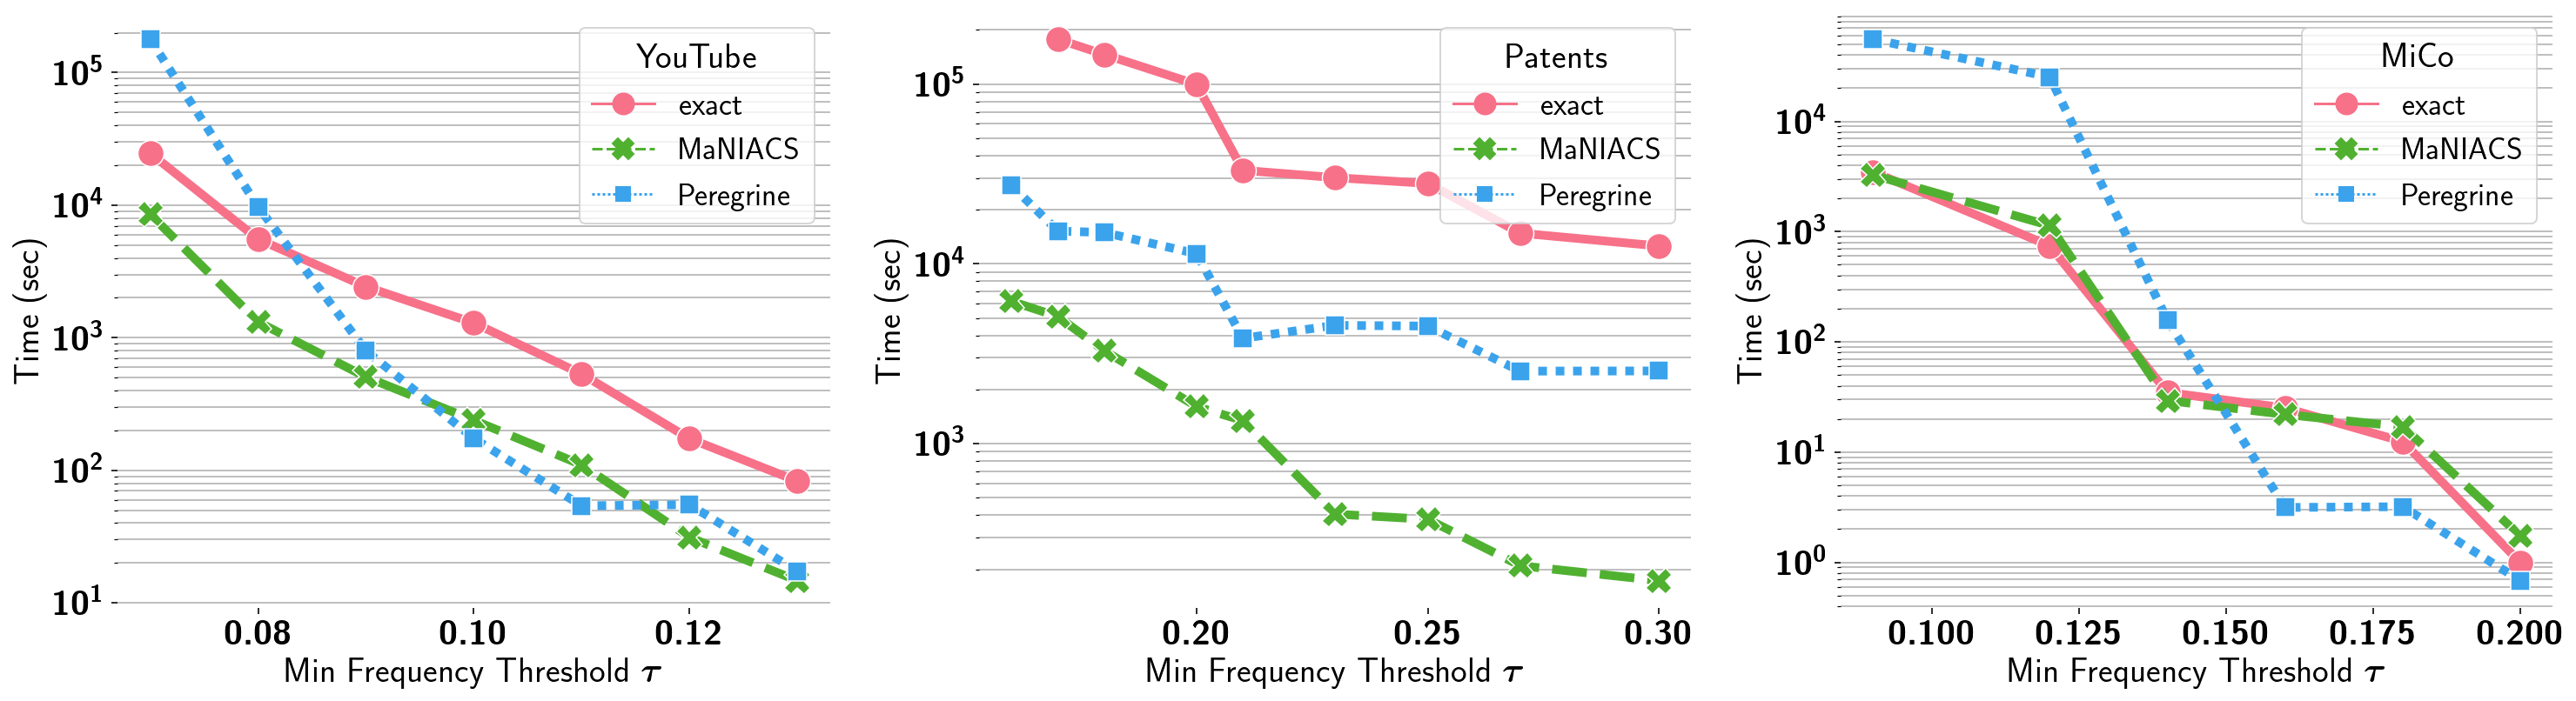

In [52]:
fig, ax = plt.subplots(1,3,figsize=(21,6))
for idx,graph in enumerate(datasets):
    thresholds = freqs[graph]
    data = maniacs_time[(maniacs_time['Graph']==graph) & (maniacs_time['Freq. Threshold'].isin(thresholds))]
    sns.lineplot(data=data, x='Freq. Threshold', y='Time', hue='Algorithm',
                 style='Algorithm', palette='husl', linewidth=5, 
                 markers=True, markersize=15, ax=ax[idx])
    # style
    ax[idx].set_yscale('log')
    ax[idx].grid(axis='y', which='both')
    ax[idx].set_ylabel('Time (sec)')
    ax[idx].set_xlabel(r'Min Frequency Threshold $\tau$')
    # legend
    ax[idx].legend(title=graph_names[graph])
plt.tight_layout()
plt.savefig(f'{fig_path}peregrine_all.pdf', bbox_inches='tight')
plt.show()

MaxAE vs Precision

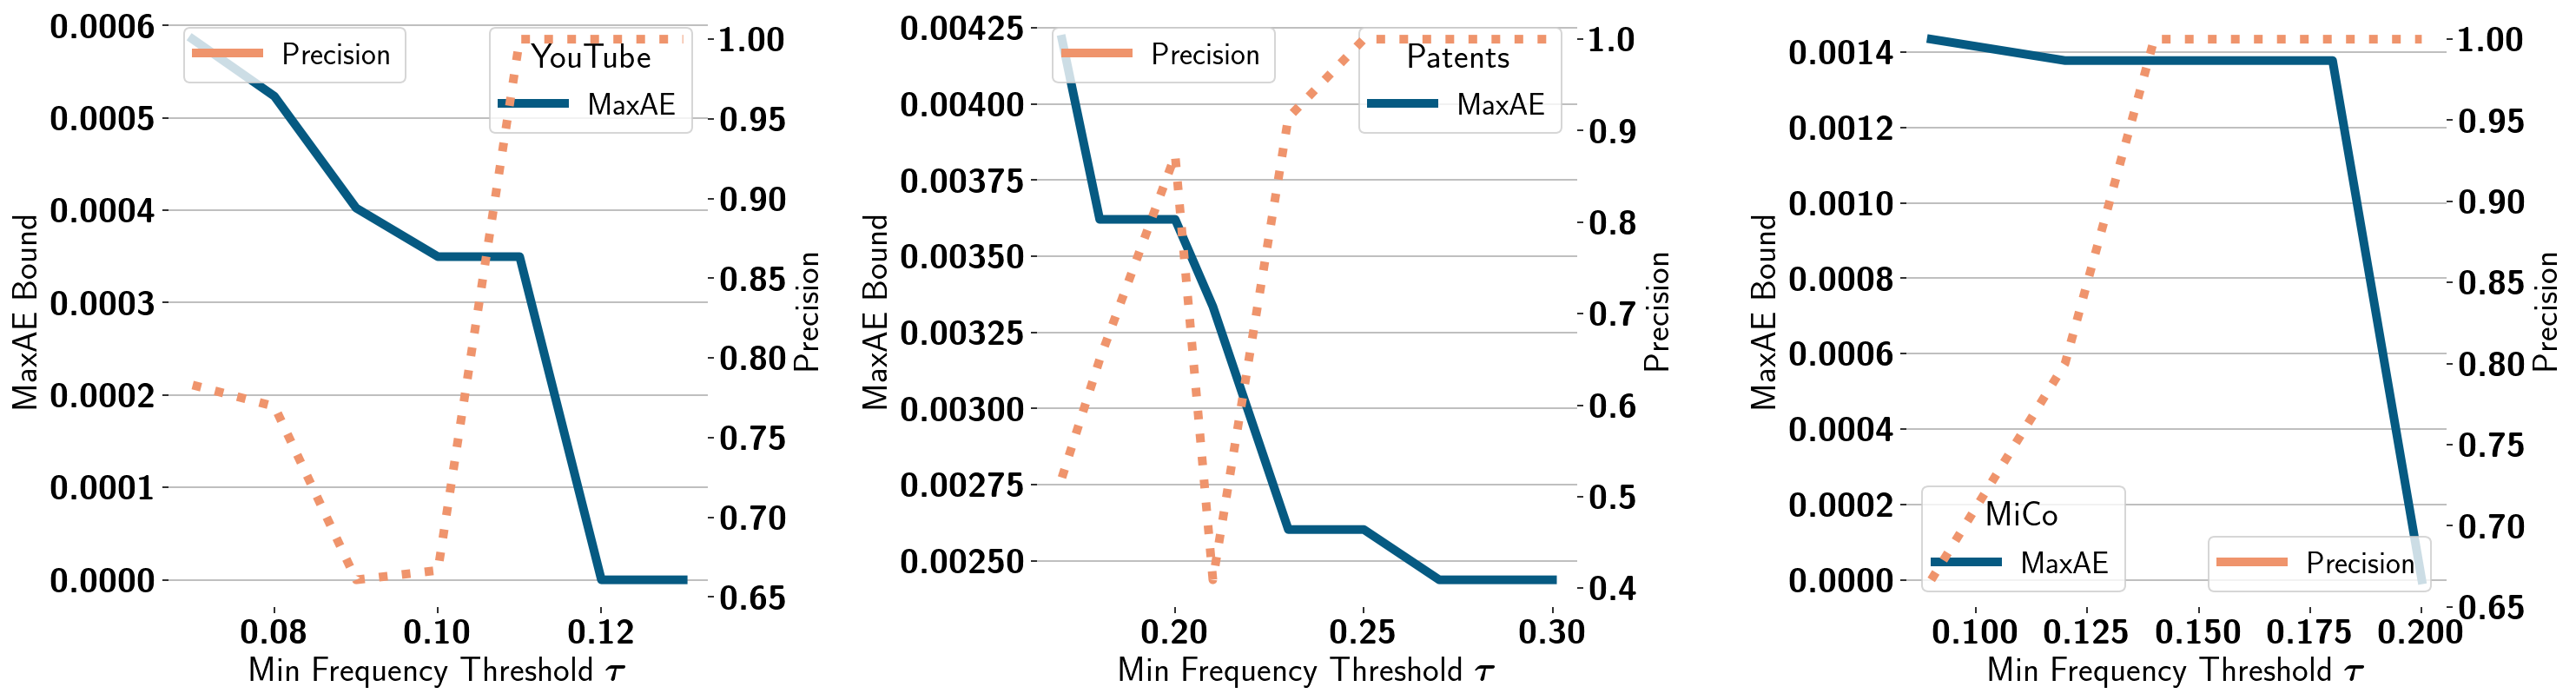

In [44]:
fig, ax = plt.subplots(1,3,figsize=(21,6))
for idx,graph in enumerate(datasets):
    thresholds = freqs[graph]
    stat = patterns_stats[(patterns_stats['Dataset']==graph) & 
                          (patterns_stats['Freq. Threshold'].isin(thresholds)) &
                          (patterns_stats['Sample Size']==selected_sample_sizes[graph]) &
                          (patterns_stats['Alpha']==1.)]
    sns.lineplot(data=stat, x='Freq. Threshold', y='MaxAE', color=palette[2], linewidth=5, 
                 label='MaxAE', markers=True, markersize=15, ax=ax[idx])
    # style
    ax[idx].grid(axis='y', which='both')
    ax[idx].set_ylabel('MaxAE Bound')
    ax[idx].set_xlabel(r'Min Frequency Threshold $\tau$')
    ax1 = ax[idx].twinx()
    sns.lineplot(data=stat, x='Freq. Threshold', y='Precision', 
                 color=palette[1], linewidth=5, label='Precision',
                 markers=True, markersize=15, ax=ax1)
    ax1.lines[0].set_linestyle(":")
    # legend
    ax[idx].legend(title=graph_names[graph])
plt.tight_layout()
plt.savefig(f'{fig_path}mae_precision_all.pdf', bbox_inches='tight')
plt.show()

# Stats Pattern Examination

In [46]:
def retrieve_stats_examination(file_name):
    with open(file_name) as in_f:
        new_config = False
        patterns = []
        vcs = []
        cands = []
        rows_vcs = []
        rows_patterns = []
        for line in in_f.readlines():
            if 'input' in line:
                if not line.startswith('input'):
                    line = line.split('\t')[-1]
                if len(vcs) > 0:
                    # graph, freq, sample, seed, alpha, vc, eps, layer, cands, non dead
                    l0 = np.concatenate((config, vcs[0], [None, None]))
                    rows_vcs.append(l0)
                    for i in range(1, len(vcs)):
                        l = np.concatenate((config, vcs[i], cands[i-1][1:]))
                        rows_vcs.append(l)
                    vcs = []
                    cands = []
                if len(patterns) > 0:
                    for p in patterns:
                        rows_patterns.append(np.concatenate((config, p)))
                    patterns = []
                lst = line.split(' ')
                # graph, freq, sample, seed, alpha
                config = [lst[0].split('=')[1], 
                           float(lst[1].split('=')[1]), 
                           int(lst[2].split('=')[1]),
                           int(lst[3].split('=')[1]),
                           float(lst[4].split('=')[1])]
            elif line.startswith('S') or line.startswith('E'): continue
            elif line.startswith('VC') and 'inputFile' not in line:
                lst = line.split('\t')
                if len(lst) == 6:
                    # layer, cand orbits, non dead orbits 
                    cands.append([int(lst[3]), int(lst[4]), int(lst[5])])
                else:
                    # vc, epsilon, layer
                    if len(vcs) == 0 or vcs[-1][-1] != int(lst[-1]):
                        vcs.append([int(lst[1]), float(lst[-2]), int(lst[-1])])
            elif line.startswith('T\t'):
                lst = line.split('\t')
                tmp = lst[2].split(' >> ')
                # time, pattern
                patterns.append([float(lst[1]), tmp[1].split(' P')[0]])
    return rows_vcs, rows_patterns

In [47]:
def retrieve_stats_exact(file_name):
    rows_vcs = []
    rows_patterns = []
    with open(file_name) as in_f:
        patterns = []
        cands = []
        for line in in_f.readlines():
            if 'input' in line:
                if not line.startswith('input'):
                    line = line.split('\t')[-1]
                if len(cands) > 0:
                    # graph, freq, layer, cands, non dead
                    for cand in cands:
                        l = np.concatenate((config, cand))
                        rows_vcs.append(l)
                    cands = []
                if len(patterns) > 0:
                    for p in patterns:
                        rows_patterns.append(np.concatenate((config, p)))
                    patterns = []
                lst = line.split(' ')
                # graph, freq
                config = [lst[0].split('=')[1], float(lst[1].split('=')[1])]
            elif line.startswith('S') or line.startswith('E'): continue
            elif line.startswith('C'):
                lst = line.split('\t')
                # layer, cand orbits, non dead orbits 
                cands.append([int(lst[1]), int(lst[2]), int(lst[3])])
            elif line.startswith('T\t'):
                lst = line.split('\t')
                tmp = lst[2].split(' >> ')
                # time, pattern
                patterns.append([float(lst[1]), tmp[1].split(' P')[0], 1])
    return rows_vcs, rows_patterns

In [48]:
def get_layer(s):
    lst = s.split(' [[')
    vertices = lst[0].split(', ')
    return len(vertices)

Approximate

In [49]:
vcs_3, patterns_3 = retrieve_stats_examination(data_dir+'logs/log_vary_alpha_3.txt')
vcs_1, patterns_1 = retrieve_stats_examination(data_dir+'logs/log_vary_alpha.txt')            
vcs_4, patterns_4 = retrieve_stats_examination(data_dir+'logs/log_vary_alpha_4.txt')        

In [50]:
R_vcs = np.append(vcs_3, vcs_1, axis=0)
R_vcs = np.append(R_vcs, vcs_4, axis=0)

In [51]:
VCS = pd.DataFrame(R_vcs, columns=['Graph', 'Freq. Threshold', 'Sample Size', 'Seed', 
                                   'Alpha',  'VC', 'Epsilon', 'Layer', 'Candidate Orbits', 'Non Dead'])

In [52]:
R_patterns = np.append(patterns_3, patterns_1, axis=0)
R_patterns = np.append(R_patterns, patterns_4, axis=0)

In [53]:
PATTERNS = pd.DataFrame(R_patterns, columns=['Graph', 'Freq. Threshold', 'Sample Size', 
                                                'Seed', 'Alpha', 'Time', 'Pattern'])

In [54]:
PATTERNS = PATTERNS.astype(dtype={'Time':np.float64,
                                  'Sample Size': np.int32,
                                  'Alpha': np.float64,
                                  'Freq. Threshold': np.float64})

Exact

In [55]:
rows_vcs, rows_patterns = retrieve_stats_exact(data_dir+'logs/log_exact.txt')

In [56]:
CANDS_EX = pd.DataFrame(rows_vcs, columns=['Graph', 'Freq. Threshold', 'Layer', 'Candidate Orbits', 'Non Dead'])

In [57]:
PATTERNS_EX = pd.DataFrame(rows_patterns, columns=['Graph', 
                                                   'Freq. Threshold', 
                                                   'Time', 
                                                   'Pattern', 
                                                   'Valid'])

In [58]:
PATTERNS_EX = PATTERNS_EX.astype(dtype={'Time':np.float64, 'Freq. Threshold': np.float64})

## Time Spent in each Layer

In [65]:
PATTERNS['Layer'] = PATTERNS['Pattern'].apply(get_layer)

In [66]:
tmp = PATTERNS.groupby(by=['Graph', 'Freq. Threshold', 'Sample Size', 'Alpha', 'Pattern', 'Layer']).mean().copy()
by_layer = tmp.reset_index().groupby(by=['Graph', 'Freq. Threshold', 'Sample Size', 'Alpha', 'Layer']).mean().reset_index()
by_layer['Num Patterns'] = tmp.reset_index().groupby(by=['Graph', 'Freq. Threshold', 'Sample Size', 'Alpha', 'Layer'])['Pattern'].count().reset_index()['Pattern']

In [67]:
R = []
for row in range(len(patterns_stats)):
    this_row = patterns_stats.iloc[row]
    epsilons = this_row[-4:].values
    for idx,e in enumerate(epsilons):
        R.append(np.append(this_row[:4].values,[e, idx+2]))

In [68]:
eps_layer = pd.DataFrame(R)
eps_layer.columns = ['Graph', 'Freq. Threshold', 'Alpha', 'Sample Size', 'Epsilon', 'Layer']
eps_layer = eps_layer.astype(dtype={'Layer':np.int32})

In [69]:
by_layer = by_layer.merge(eps_layer)

In [70]:
exam_freq = {'mico.lg': [0.09, 0.12],
             'youtube.lg': [0.08, 0.09],
             'patents_decade.lg': [0.18, 0.23]}

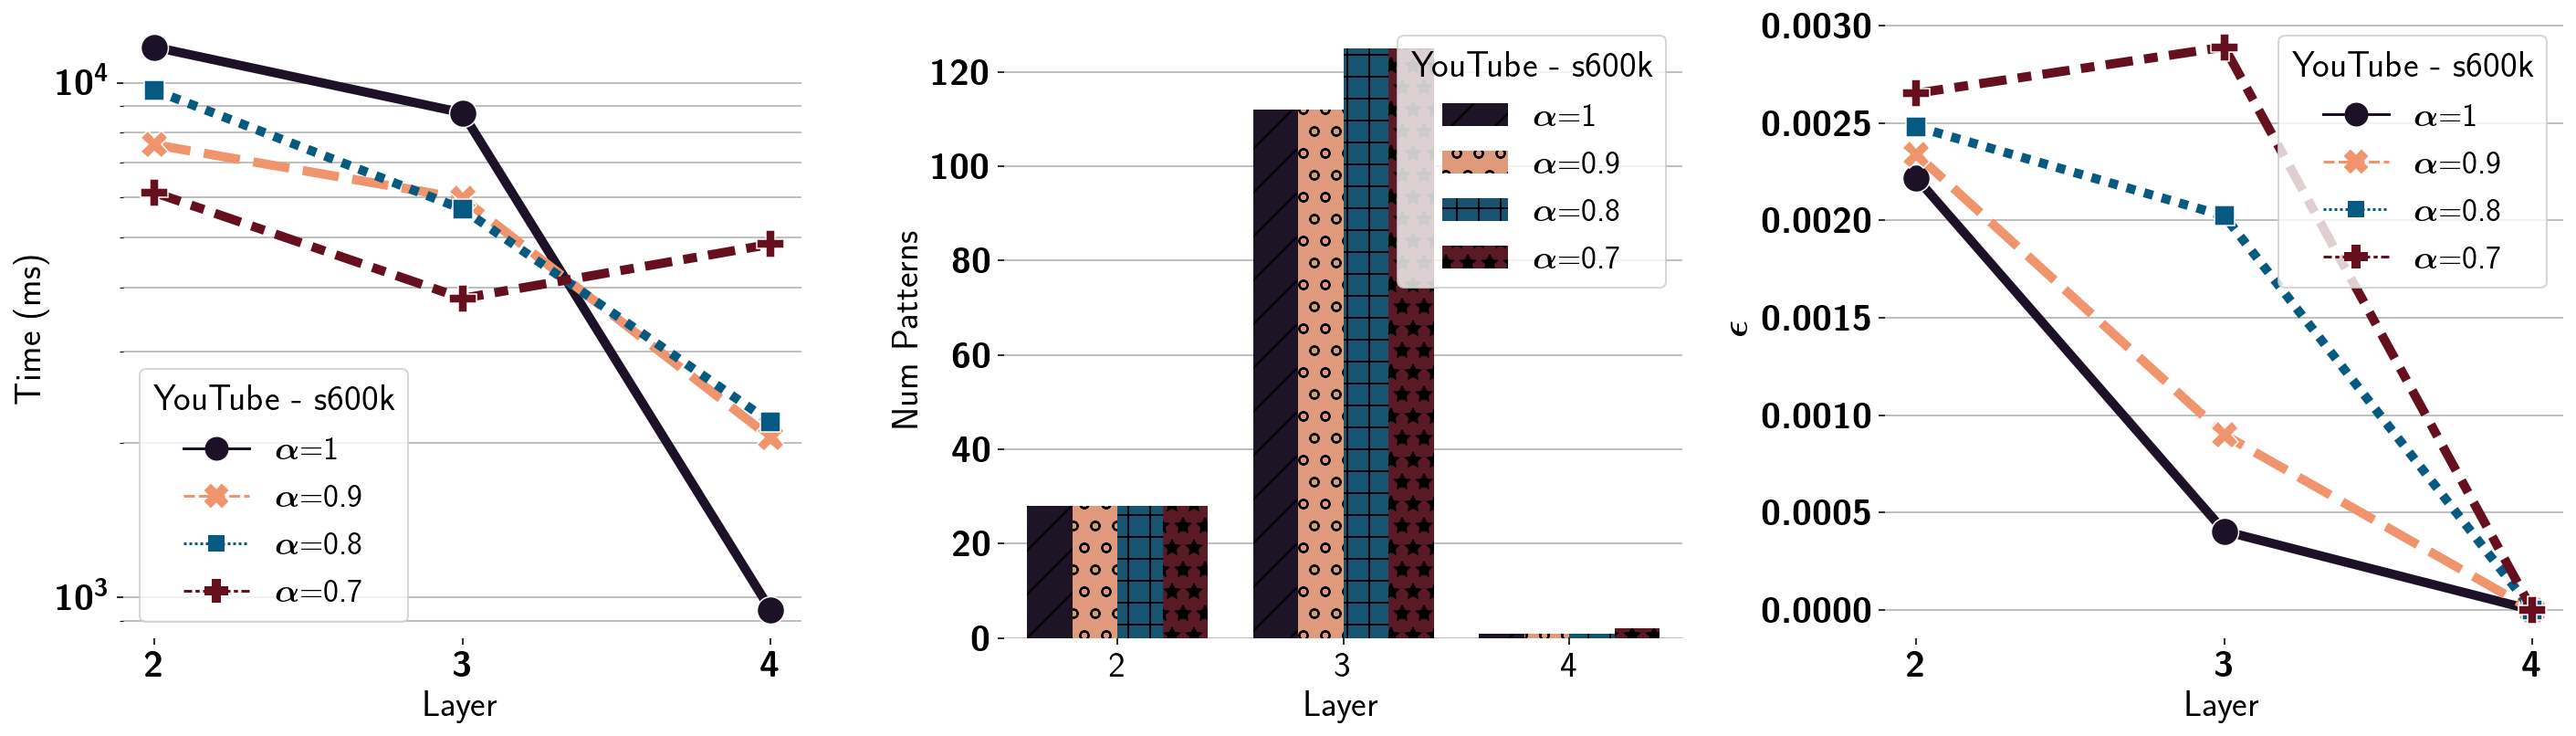

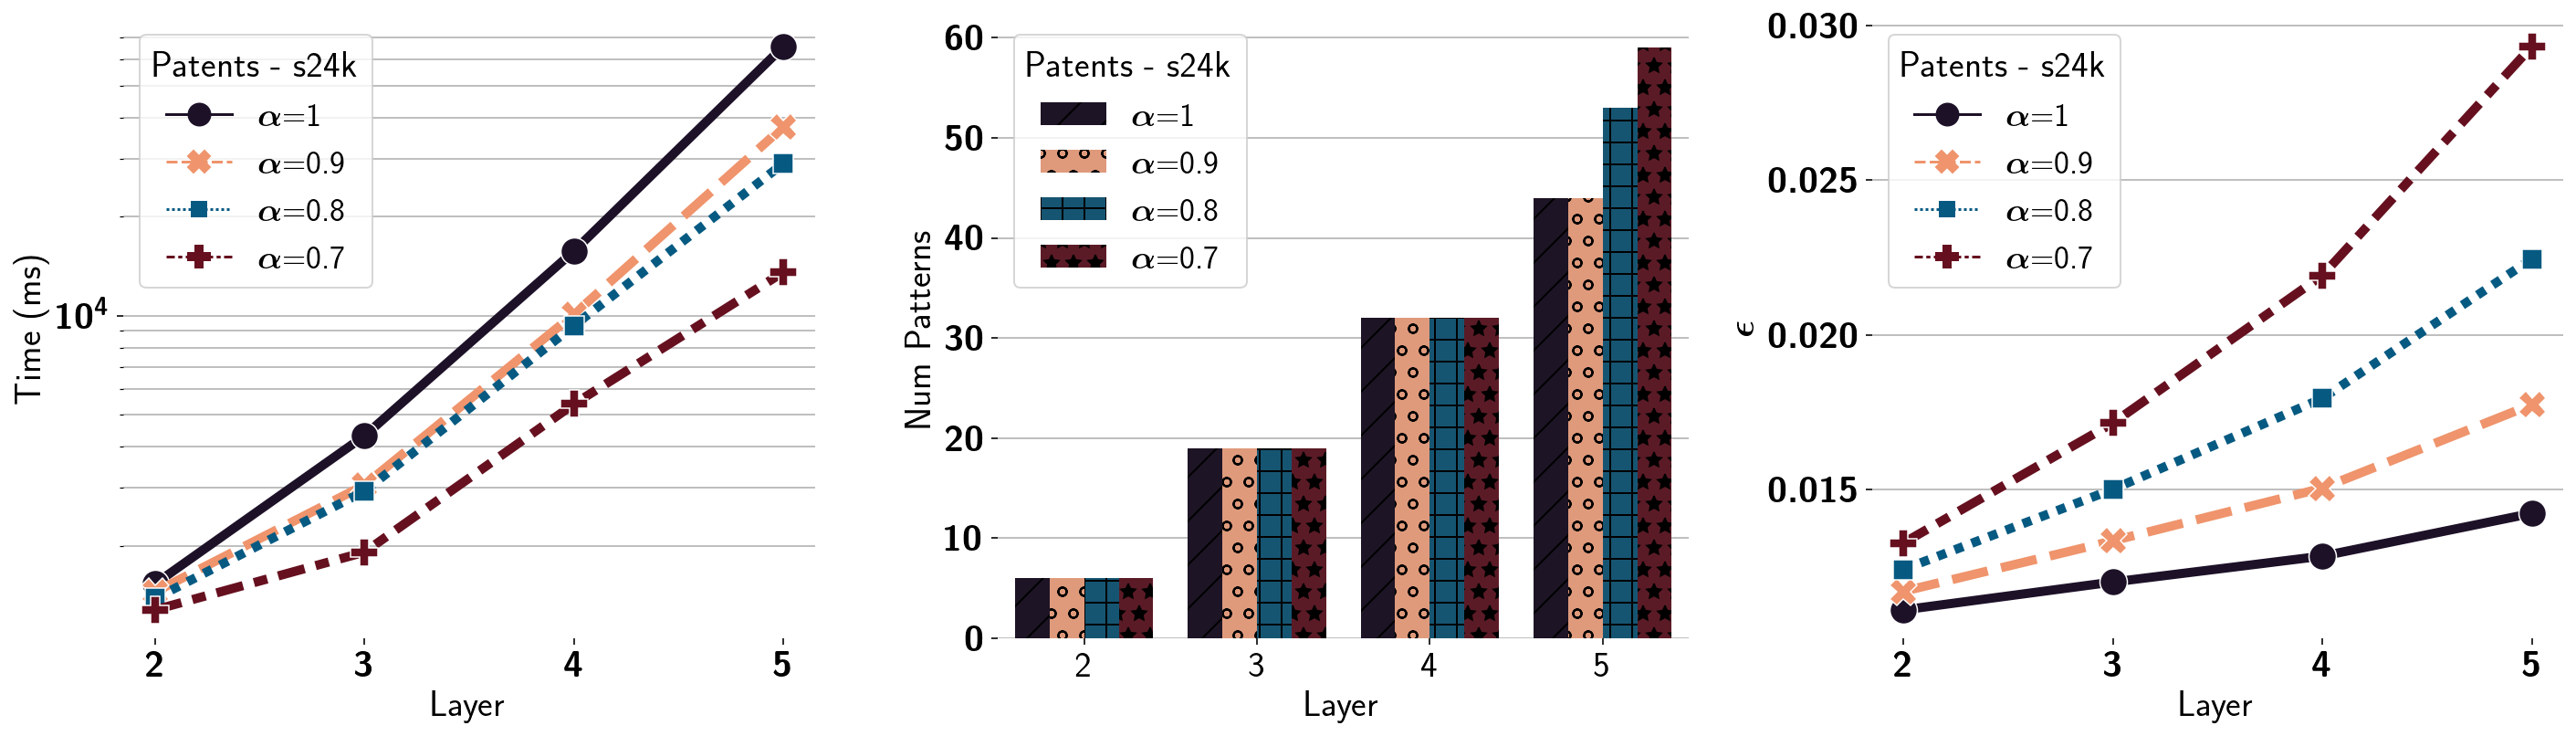

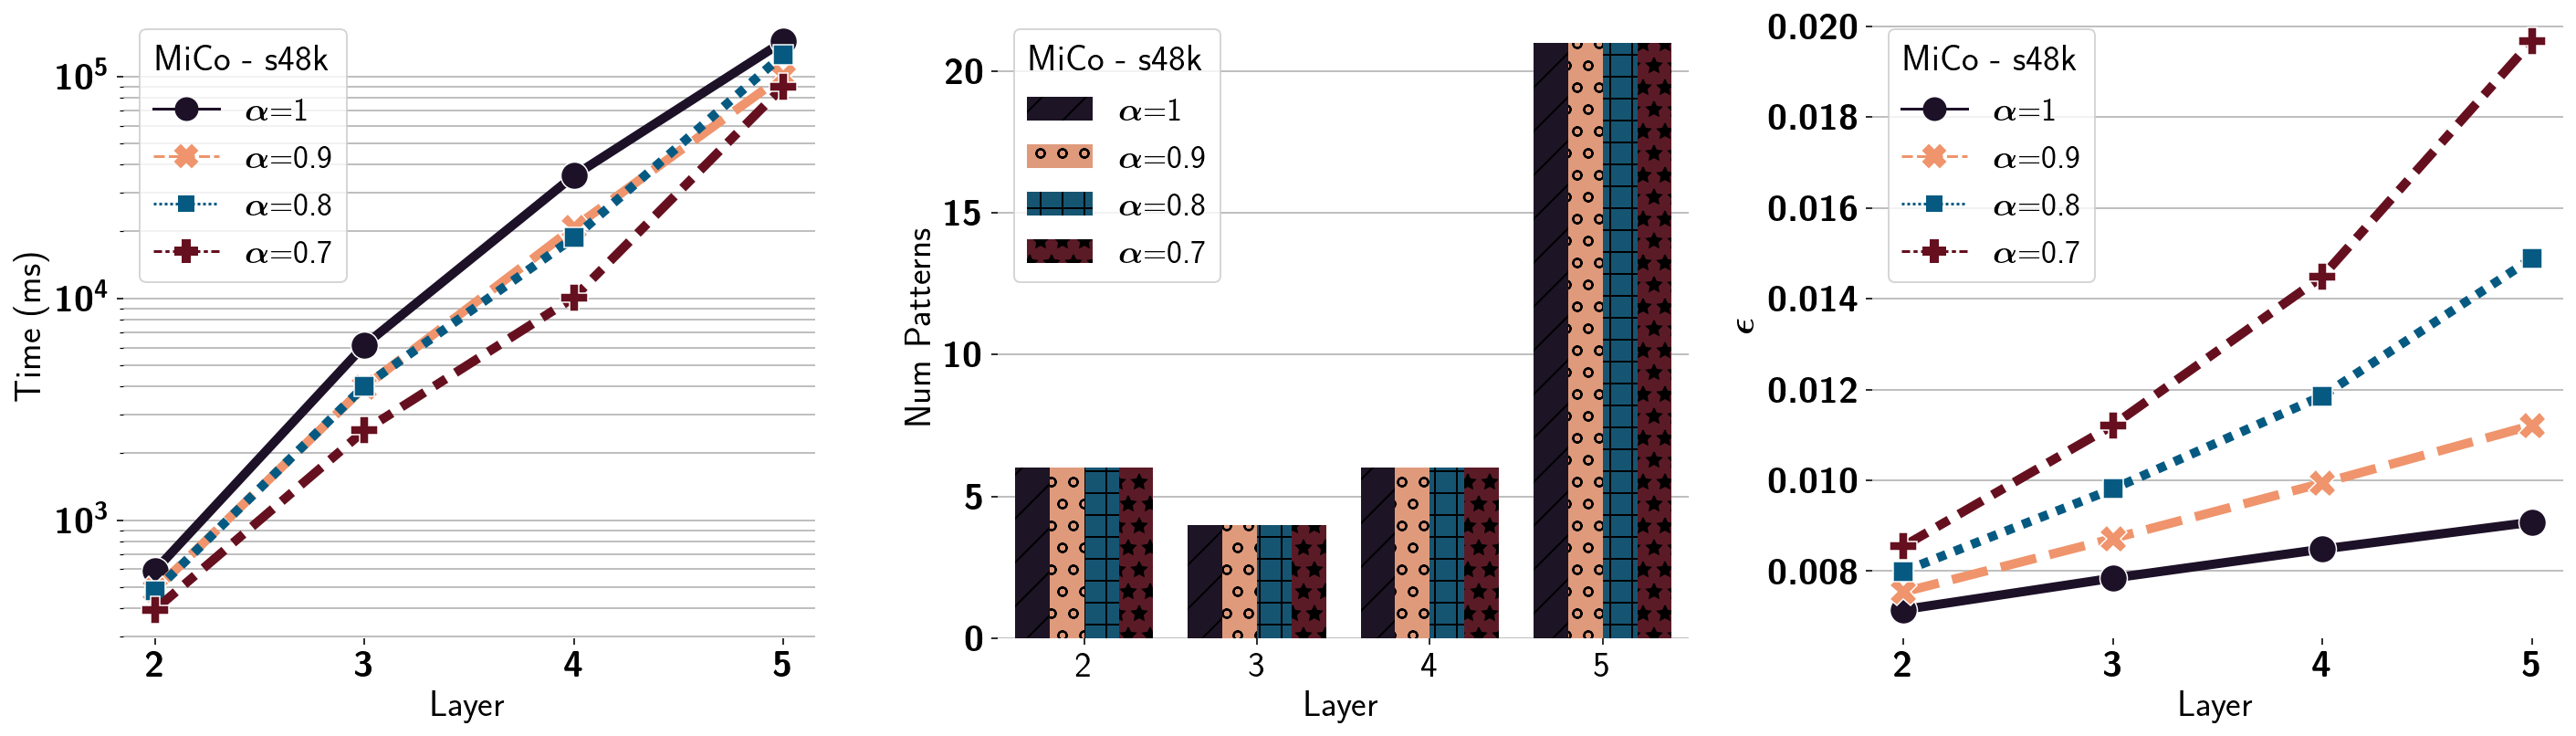

In [75]:
for g in datasets:
    data = by_layer[(by_layer['Graph']==g) & (by_layer['Alpha']>0.4) &
                    (by_layer['Sample Size'].isin(subset_sizes[g]))].copy()
    data['Sample Size'] = data['Sample Size'].apply(str) + ' ' + data['Alpha'].apply(str)
    data['Sample Size'] = data['Sample Size'].apply(rename_sample_size_with_alpha)
    data = data.sort_values(by='Alpha', ascending=False)
    data['Alpha'] = data['Alpha'].apply(rename_alpha)
    first = data[data['Freq. Threshold']==exam_freq[g][0]].copy()
    second = data[data['Freq. Threshold']==exam_freq[g][1]].copy()
    
    fig, ax = plt.subplots(1, 3, figsize=(20,6))
    # time
    sns.lineplot(data=first, x='Layer', y='Time', hue='Alpha', style='Alpha', 
                 ax=ax[0], markers=True, markersize=15, linewidth=5, palette=palette[:4])
    ax[0].set_ylabel('Time (ms)')
    ax[0].set_yscale('log')
    ax[0].grid(axis='y', which='both')
    ax[0].set_xticks(first['Layer'].unique())
    ax[0].legend(title=graph_names[g]+' - '+rename_sample_size(subset_sizes[g][0]))
    # num patterns
    sns.barplot(data=first, x='Layer', y='Num Patterns', hue='Alpha', 
                palette=palette, ax=ax[1])
    size = len(first['Layer'].unique())
    hatches = itertools.cycle(['/', 'o', '+', '*', 'x', '\\', '-', '//', 'O', '.'])
    for i, bar in enumerate(ax[1].patches):
        if i % size == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
    ax[1].grid(axis='y')
    ax[1].set_axisbelow(True)
    ax[1].legend(title=graph_names[g]+' - '+rename_sample_size(subset_sizes[g][0]))
    # epsilon
    sns.lineplot(data=first, x='Layer', y='Epsilon', linewidth=5, hue='Alpha', 
                style='Alpha', ax=ax[2], markers=True, markersize=15, palette=palette[:4])
    ax[2].set_xticks(first['Layer'].unique())
    ax[2].set_ylabel(r'$\epsilon$')
    ax[2].grid(axis='y')
    ax[2].legend(title=graph_names[g]+' - '+rename_sample_size(subset_sizes[g][0]))
    plt.tight_layout()
    plt.savefig(fig_path+'patterns_by_layer_'+g+'.pdf')
    plt.show()

# Number of Labeled Patterns

In [ ]:
def get_num_labeled_patterns(m):
    num_patterns = []
    num_patterns.append((m**3 + m**2)/2)
    num_patterns.append((m**3 + 3*m**2 + 2*m)/6)
    num_patterns.append((m**4 + m**2)/2)
    num_patterns.append((m**4 + 3*m**3 + 2*m**2)/6)
    num_patterns.append((m**4 + 2*m**3 + 3*m**2 + 2*m)/8)
    num_patterns.append((m**4 + m**3)/2) 
    num_patterns.append((m**4 + 2*m**3 + m**2)/4) 
    num_patterns.append((m**4 + 6 * m**3 + 11 * m**2 + 6*m)/24) 
    num_patterns.append((m**5 + m**3) / 2 )
    num_patterns.append((m**5 + m**4)/2 )
    num_patterns.append((m**5 + 6*m**4 + 11 * m**3 + 6*m**2)/24 )
    num_patterns.append((m**5+m**3) / 2 )
    num_patterns.append((m**5 + m**4)/2 )
    num_patterns.append((m**5 + 2*m**4 + m**3)/4 )
    num_patterns.append((m**5+5*m**3+4*m) / 10 )
    num_patterns.append((m**5 + m**4)/2 )
    num_patterns.append((m**5 + m**4)/2 )
    num_patterns.append((m**5 + 2*m**4 + 3*m**3 + 2*m**2) / 8 )
    num_patterns.append((m**5 + m**4)/2 )
    num_patterns.append((m**5 + 4*m**4 + 5*m**3 +2*m**2)/12)
    num_patterns.append((m**5+m**3) / 2 )
    num_patterns.append((m**5 + 4*m**4 + 5*m**3 +2*m**2)/12)
    num_patterns.append((m**5 + 3*m**4 + 2*m**3)/6 )
    num_patterns.append((m**5+m**3) / 2)
    num_patterns.append((m**5 + 2*m**4 + m**3)/4 )
    num_patterns.append((m**5 + 2*m**4 + m**3)/4 )
    num_patterns.append((m**5+2*m**4+3*m**3+2*m**2) / 8  )
    num_patterns.append((m**5 + 4*m**4 + 5*m**3 + 2*m**2)/12)
    num_patterns.append(len(list(combinations(range(m+4),5))))
    P = np.array(num_patterns)
    print('Mean L3', np.mean(P[:2]), 'Mean L4', np.mean(P[2:8]), 'Mean L5', np.mean(P[8:]))
    return np.mean(P), np.sum(P), np.min(P), np.max(P)

In [74]:
get_num_labeled_patterns(4)

Mean L3 30.0 Mean L4 94.33333333333333 Mean L5 393.7142857142857


(306.6896551724138, 8894.0, 20.0, 640.0)